In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 7.8MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 163kB 13.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 143kB 16.0MB/s 
     |████████████████████████████████| 112kB 16.5MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=33cfff4af3d314c892605a0c707b5d373b3309457dc70adb502d5430e03a4c15
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("tanimura/*/")
data = []
label = [] 
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['kaibara_159.jpg', 'kaibara_160.jpg', 'kaibara_161.jpg', 'kaibara_162.jpg', 'kaibara_163.jpg', 'kaibara_164.jpg', 'kaibara_165.jpg', 'kaibara_166.jpg', 'kaibara_167.jpg', 'kaibara_168.jpg', 'kaibara_169.jpg', 'kaibara_170.jpg', 'kaibara_171.jpg', 'kaibara_172.jpg', 'kaibara_173.jpg', 'kaibara_174.jpg', 'kaibara_175.jpg', 'kaibara_176.jpg', 'kaibara_177.jpg', 'kaibara_178.jpg', 'ohhara_192.jpg', 'kurita_163.jpg', 'tomii_157.jpg', 'tomii_158.jpg', 'yamaoka_171.jpg', 'tomii_159.jpg', 'kurita_164.jpg', 'yamaoka_172.jpg', 'kurita_165.jpg', 'yamaoka_173.jpg', 'tomii_160.jpg', 'tomii_161.jpg', 'tomii_162.jpg', 'yamaoka_174.jpg', 'tomii_163.jpg', 'tomii_164.jpg', 'tomii_165.jpg', 'yamaoka_175.jpg', 'kurita_166.jpg', 'yamaoka_176.jpg', 'ohhara_193.jpg', 'ohhara_194.jpg', 'ohhara_195.jpg', 'ohhara_196.jpg', 'ohhara_198.jpg', 'ohhara_199.jpg', 'ohhara_001.jpg', 'ohhara_002.jpg', 'ohhara_003.jpg', 'ohhara_004.jpg', 'ohhara_005.jpg', 'ohhara_006.jpg', 'ohhara_007.jpg', 'ohhara_008.jpg', 'yamaoka_1

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 06:50:42,058] A new study created in memory with name: no-name-284e65b7-6134-410b-9686-8d1fd746b568


18
Epoch 1/16
64/64 - 34s - loss: 0.4388 - accuracy: 0.8733 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3597 - accuracy: 0.8785 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3574 - accuracy: 0.8759 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3581 - accuracy: 0.8750 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3518 - accuracy: 0.8776 - val_loss: 0.3758 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3524 - accuracy: 0.8828 - val_loss: 0.3758 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8776 - val_loss: 0.3758 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8767 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3579 - accuracy: 0.8793 - val_loss: 0.3680 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3464 - accuracy: 0.8811 - val_loss: 0.3648 - val_accuracy: 0.8760
Epoch 11/16
64/

[I 2021-03-17 06:51:25,603] Trial 0 finished with value: 0.13178294897079468 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.38727788648554407}. Best is trial 0 with value: 0.13178294897079468.


Epoch 1/16
64/64 - 1s - loss: 0.9519 - accuracy: 0.5990 - val_loss: 0.3869 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6557 - accuracy: 0.7005 - val_loss: 0.3809 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5217 - accuracy: 0.7769 - val_loss: 0.3562 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5051 - accuracy: 0.7960 - val_loss: 0.3635 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4234 - accuracy: 0.8429 - val_loss: 0.3773 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8281 - val_loss: 0.3599 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3850 - accuracy: 0.8568 - val_loss: 0.3216 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3591 - accuracy: 0.8655 - val_loss: 0.3216 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3302 - accuracy: 0.8689 - val_loss: 0.3290 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3180 - accuracy: 0.8802 - val_loss: 0.3280 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:51:30,879] Trial 1 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3959523277433546}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 2s - loss: 0.6514 - accuracy: 0.8724 - val_loss: 0.6212 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6006 - accuracy: 0.8785 - val_loss: 0.5831 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5678 - accuracy: 0.8785 - val_loss: 0.5555 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5435 - accuracy: 0.8785 - val_loss: 0.5336 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5233 - accuracy: 0.8785 - val_loss: 0.5154 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.5063 - accuracy: 0.8785 - val_loss: 0.4998 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4914 - accuracy: 0.8785 - val_loss: 0.4863 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4781 - accuracy: 0.8785 - val_loss: 0.4744 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4672 - accuracy: 0.8785 - val_loss: 0.4639 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4563 - accuracy: 0.8785 - val_loss: 0.4545 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:51:36,890] Trial 2 finished with value: 0.12403100728988647 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.2912129763239981}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 1s - loss: 0.5035 - accuracy: 0.8733 - val_loss: 0.3976 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8785 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3642 - accuracy: 0.8785 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8785 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3569 - accuracy: 0.8785 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3568 - accuracy: 0.8785 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3613 - accuracy: 0.8776 - val_loss: 0.3742 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3572 - accuracy: 0.8802 - val_loss: 0.3729 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8776 - val_loss: 0.3687 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3430 - accuracy: 0.8828 - val_loss: 0.3654 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:51:41,961] Trial 3 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.48548142468415445}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 2s - loss: 1.0978 - accuracy: 0.4878 - val_loss: 0.9294 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 1.0698 - accuracy: 0.4913 - val_loss: 1.1396 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 1.0956 - accuracy: 0.4826 - val_loss: 1.2364 - val_accuracy: 0.1240
Epoch 4/16
64/64 - 0s - loss: 1.1088 - accuracy: 0.4800 - val_loss: 1.2880 - val_accuracy: 0.1240
Epoch 5/16
64/64 - 0s - loss: 1.1363 - accuracy: 0.4905 - val_loss: 1.3063 - val_accuracy: 0.1240
Epoch 6/16
64/64 - 0s - loss: 1.0890 - accuracy: 0.5017 - val_loss: 1.2268 - val_accuracy: 0.1395
Epoch 7/16
64/64 - 0s - loss: 1.0932 - accuracy: 0.5043 - val_loss: 1.1509 - val_accuracy: 0.1705
Epoch 8/16
64/64 - 0s - loss: 1.0767 - accuracy: 0.4983 - val_loss: 1.1041 - val_accuracy: 0.2248
Epoch 9/16
64/64 - 0s - loss: 1.0482 - accuracy: 0.4983 - val_loss: 1.0967 - val_accuracy: 0.2093
Epoch 10/16
64/64 - 0s - loss: 1.0724 - accuracy: 0.5061 - val_loss: 1.0886 - val_accuracy: 0.2481
Epoch 11/16
64/64 -

[I 2021-03-17 06:51:48,039] Trial 4 finished with value: 0.6899224817752838 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'relu', 'dropout_rate': 0.3175125830287554}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 2s - loss: 0.8868 - accuracy: 0.6224 - val_loss: 0.3982 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5427 - accuracy: 0.7682 - val_loss: 0.3776 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5253 - accuracy: 0.7839 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4585 - accuracy: 0.8385 - val_loss: 0.3765 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4246 - accuracy: 0.8394 - val_loss: 0.3731 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4206 - accuracy: 0.8490 - val_loss: 0.3867 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4210 - accuracy: 0.8411 - val_loss: 0.3945 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4071 - accuracy: 0.8507 - val_loss: 0.4204 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4292 - accuracy: 0.8542 - val_loss: 0.3920 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4040 - accuracy: 0.8464 - val_loss: 0.3837 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:51:54,519] Trial 5 finished with value: 0.13178294897079468 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.30877627108123207}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 4s - loss: 0.9082 - accuracy: 0.5677 - val_loss: 0.6545 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 1s - loss: 0.6422 - accuracy: 0.6858 - val_loss: 0.4568 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 1s - loss: 0.5287 - accuracy: 0.7726 - val_loss: 0.3993 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 1s - loss: 0.4835 - accuracy: 0.8012 - val_loss: 0.3827 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 1s - loss: 0.4250 - accuracy: 0.8325 - val_loss: 0.3730 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 1s - loss: 0.4323 - accuracy: 0.8472 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 1s - loss: 0.4087 - accuracy: 0.8568 - val_loss: 0.3677 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 1s - loss: 0.4120 - accuracy: 0.8533 - val_loss: 0.3668 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 1s - loss: 0.4174 - accuracy: 0.8585 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 1s - loss: 0.4009 - accuracy: 0.8628 - val_loss: 0.3675 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:07,536] Trial 6 finished with value: 0.12403100728988647 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 32, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.32851205587953386}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 2s - loss: 1.2145 - accuracy: 0.5148 - val_loss: 0.3946 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 1.1716 - accuracy: 0.5061 - val_loss: 0.3805 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 1.1655 - accuracy: 0.5113 - val_loss: 0.3935 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 1.1594 - accuracy: 0.5165 - val_loss: 0.4119 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 1.2185 - accuracy: 0.5182 - val_loss: 0.4400 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 1.1598 - accuracy: 0.5269 - val_loss: 0.4747 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 1.1774 - accuracy: 0.5165 - val_loss: 0.5108 - val_accuracy: 0.7209
Epoch 8/16
64/64 - 0s - loss: 1.1298 - accuracy: 0.5191 - val_loss: 0.5579 - val_accuracy: 0.7054
Epoch 9/16
64/64 - 0s - loss: 1.1725 - accuracy: 0.5191 - val_loss: 0.5970 - val_accuracy: 0.6899
Epoch 10/16
64/64 - 0s - loss: 1.1116 - accuracy: 0.5304 - val_loss: 0.6347 - val_accuracy: 0.6589
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:13,728] Trial 7 finished with value: 0.3488371968269348 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'selu', 'dropout_rate': 0.35259295815136615}. Best is trial 1 with value: 0.12403100728988647.


Epoch 1/16
64/64 - 1s - loss: 0.8597 - accuracy: 0.6415 - val_loss: 0.4738 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5798 - accuracy: 0.7639 - val_loss: 0.3849 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4735 - accuracy: 0.8220 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4183 - accuracy: 0.8212 - val_loss: 0.3676 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8620 - val_loss: 0.3812 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.8898 - val_loss: 0.3399 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8767 - val_loss: 0.3291 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2482 - accuracy: 0.8958 - val_loss: 0.3465 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2291 - accuracy: 0.9010 - val_loss: 0.3244 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1895 - accuracy: 0.9280 - val_loss: 0.3224 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:18,071] Trial 8 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.42800899510947876}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 0.9013 - accuracy: 0.5773 - val_loss: 0.5179 - val_accuracy: 0.7984
Epoch 2/16
64/64 - 0s - loss: 0.6382 - accuracy: 0.6762 - val_loss: 0.4172 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5391 - accuracy: 0.7517 - val_loss: 0.3699 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4635 - accuracy: 0.8047 - val_loss: 0.3657 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4732 - accuracy: 0.8116 - val_loss: 0.3625 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4225 - accuracy: 0.8342 - val_loss: 0.3668 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4312 - accuracy: 0.8411 - val_loss: 0.3674 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.4120 - accuracy: 0.8420 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8377 - val_loss: 0.3707 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3983 - accuracy: 0.8498 - val_loss: 0.4030 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:25,297] Trial 9 finished with value: 0.1627907156944275 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.30580275221523145}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9107 - accuracy: 0.6215 - val_loss: 0.4502 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5298 - accuracy: 0.7743 - val_loss: 0.3983 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4513 - accuracy: 0.8203 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3888 - accuracy: 0.8715 - val_loss: 0.3497 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2931 - accuracy: 0.8958 - val_loss: 0.3590 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2475 - accuracy: 0.9201 - val_loss: 0.3451 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9280 - val_loss: 0.4851 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1730 - accuracy: 0.9444 - val_loss: 0.3672 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1434 - accuracy: 0.9488 - val_loss: 0.3466 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1167 - accuracy: 0.9566 - val_loss: 0.3620 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:29,097] Trial 10 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4609966849552853}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9172 - accuracy: 0.6241 - val_loss: 0.5051 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5702 - accuracy: 0.7700 - val_loss: 0.4004 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4802 - accuracy: 0.7995 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3978 - accuracy: 0.8559 - val_loss: 0.3554 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3263 - accuracy: 0.8663 - val_loss: 0.3505 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8889 - val_loss: 0.3469 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2508 - accuracy: 0.9097 - val_loss: 0.3780 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9089 - val_loss: 0.3430 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1960 - accuracy: 0.9253 - val_loss: 0.4202 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1906 - accuracy: 0.9271 - val_loss: 0.4777 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:33,130] Trial 11 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4593712342811364}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8672 - accuracy: 0.6554 - val_loss: 0.5122 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5260 - accuracy: 0.8038 - val_loss: 0.3971 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4622 - accuracy: 0.8359 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3940 - accuracy: 0.8620 - val_loss: 0.3537 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3270 - accuracy: 0.8776 - val_loss: 0.3378 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2614 - accuracy: 0.9019 - val_loss: 0.3547 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9132 - val_loss: 0.3224 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1571 - accuracy: 0.9453 - val_loss: 0.3241 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1358 - accuracy: 0.9531 - val_loss: 0.4527 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0923 - accuracy: 0.9661 - val_loss: 0.3474 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:36,948] Trial 12 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.43453992056685464}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8065 - accuracy: 0.6519 - val_loss: 0.4473 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5554 - accuracy: 0.7726 - val_loss: 0.3816 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4416 - accuracy: 0.8307 - val_loss: 0.3687 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3878 - accuracy: 0.8594 - val_loss: 0.3613 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3327 - accuracy: 0.8741 - val_loss: 0.3545 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2920 - accuracy: 0.8776 - val_loss: 0.3440 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2593 - accuracy: 0.8967 - val_loss: 0.3401 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9132 - val_loss: 0.3383 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9323 - val_loss: 0.3995 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9392 - val_loss: 0.3483 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:40,640] Trial 13 finished with value: 0.1860465407371521 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.42979780424591796}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8999 - accuracy: 0.6198 - val_loss: 0.3703 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.7212 - accuracy: 0.7214 - val_loss: 0.3892 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5426 - accuracy: 0.7943 - val_loss: 0.4154 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4841 - accuracy: 0.8273 - val_loss: 0.4066 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4670 - accuracy: 0.8481 - val_loss: 0.4051 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4436 - accuracy: 0.8611 - val_loss: 0.3771 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4554 - accuracy: 0.8628 - val_loss: 0.3792 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4804 - accuracy: 0.8576 - val_loss: 0.4588 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4575 - accuracy: 0.8628 - val_loss: 0.4175 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4081 - accuracy: 0.8637 - val_loss: 0.3858 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:45,050] Trial 14 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.49898436579967376}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8948 - accuracy: 0.6337 - val_loss: 0.5025 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5821 - accuracy: 0.7517 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4613 - accuracy: 0.8142 - val_loss: 0.3683 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4265 - accuracy: 0.8333 - val_loss: 0.3866 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3975 - accuracy: 0.8438 - val_loss: 0.3654 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3560 - accuracy: 0.8594 - val_loss: 0.3526 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3069 - accuracy: 0.8819 - val_loss: 0.3524 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2715 - accuracy: 0.8889 - val_loss: 0.3566 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8837 - val_loss: 0.3329 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2329 - accuracy: 0.9175 - val_loss: 0.3649 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:49,472] Trial 15 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.422390945699939}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9698 - accuracy: 0.6042 - val_loss: 0.3840 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6268 - accuracy: 0.7517 - val_loss: 0.3731 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5084 - accuracy: 0.8030 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4890 - accuracy: 0.8316 - val_loss: 0.3832 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4514 - accuracy: 0.8377 - val_loss: 0.4767 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8411 - val_loss: 0.3808 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3992 - accuracy: 0.8602 - val_loss: 0.3795 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3756 - accuracy: 0.8498 - val_loss: 0.4155 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.3683 - accuracy: 0.8620 - val_loss: 0.4324 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3426 - accuracy: 0.8698 - val_loss: 0.5203 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:53,843] Trial 16 finished with value: 0.1627907156944275 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'softsign', 'dropout_rate': 0.464195566091299}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.0577 - accuracy: 0.5616 - val_loss: 0.5006 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.7114 - accuracy: 0.6649 - val_loss: 0.4062 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.6128 - accuracy: 0.7457 - val_loss: 0.3809 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5027 - accuracy: 0.8021 - val_loss: 0.3700 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5086 - accuracy: 0.8238 - val_loss: 0.3705 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4752 - accuracy: 0.8299 - val_loss: 0.3678 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4210 - accuracy: 0.8516 - val_loss: 0.3719 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4285 - accuracy: 0.8550 - val_loss: 0.3740 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4130 - accuracy: 0.8533 - val_loss: 0.3777 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4372 - accuracy: 0.8550 - val_loss: 0.3781 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:52:59,258] Trial 17 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.47219390526611554}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9022 - accuracy: 0.6363 - val_loss: 0.3705 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5102 - accuracy: 0.7908 - val_loss: 0.3698 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3452 - accuracy: 0.8655 - val_loss: 0.3661 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3167 - accuracy: 0.8767 - val_loss: 0.3951 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2509 - accuracy: 0.9036 - val_loss: 0.3502 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2091 - accuracy: 0.9227 - val_loss: 0.3212 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9375 - val_loss: 0.3285 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9488 - val_loss: 0.3655 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0986 - accuracy: 0.9670 - val_loss: 0.3335 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1123 - accuracy: 0.9549 - val_loss: 0.3614 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:04,516] Trial 18 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.41597654614848245}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.7366 - accuracy: 0.6424 - val_loss: 0.4564 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5119 - accuracy: 0.7839 - val_loss: 0.4539 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4168 - accuracy: 0.8255 - val_loss: 0.3929 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3443 - accuracy: 0.8707 - val_loss: 0.3637 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3042 - accuracy: 0.8793 - val_loss: 0.3496 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2400 - accuracy: 0.9097 - val_loss: 0.3378 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2118 - accuracy: 0.9236 - val_loss: 0.3323 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1754 - accuracy: 0.9410 - val_loss: 0.3307 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9488 - val_loss: 0.3503 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1266 - accuracy: 0.9479 - val_loss: 0.3521 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:09,667] Trial 19 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.26112222995910506}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8793 - accuracy: 0.6050 - val_loss: 0.3844 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5795 - accuracy: 0.7526 - val_loss: 0.3724 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4759 - accuracy: 0.7995 - val_loss: 0.3738 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.8385 - val_loss: 0.3640 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3993 - accuracy: 0.8507 - val_loss: 0.3576 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8472 - val_loss: 0.3537 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3648 - accuracy: 0.8594 - val_loss: 0.3631 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8585 - val_loss: 0.3573 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3740 - accuracy: 0.8464 - val_loss: 0.3501 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3655 - accuracy: 0.8611 - val_loss: 0.3463 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:14,802] Trial 20 finished with value: 0.14728683233261108 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.36573916692638553}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.1042 - accuracy: 0.5425 - val_loss: 0.4231 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.9755 - accuracy: 0.5781 - val_loss: 0.4062 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.8769 - accuracy: 0.6120 - val_loss: 0.3809 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.7767 - accuracy: 0.6406 - val_loss: 0.3918 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.7738 - accuracy: 0.6510 - val_loss: 0.4179 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.7797 - accuracy: 0.6510 - val_loss: 0.3867 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.7729 - accuracy: 0.6406 - val_loss: 0.3832 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.7347 - accuracy: 0.6641 - val_loss: 0.4228 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.7209 - accuracy: 0.6780 - val_loss: 0.4391 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.6403 - accuracy: 0.6944 - val_loss: 0.4916 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:19,956] Trial 21 finished with value: 0.1705426573753357 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.39931551053784514}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.0537 - accuracy: 0.5556 - val_loss: 0.4558 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.8009 - accuracy: 0.6432 - val_loss: 0.4374 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.6700 - accuracy: 0.6979 - val_loss: 0.4044 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.6119 - accuracy: 0.7344 - val_loss: 0.3815 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5925 - accuracy: 0.7561 - val_loss: 0.3677 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.5259 - accuracy: 0.7951 - val_loss: 0.3646 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.5025 - accuracy: 0.8090 - val_loss: 0.3658 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4825 - accuracy: 0.8099 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4682 - accuracy: 0.8307 - val_loss: 0.3621 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4531 - accuracy: 0.8247 - val_loss: 0.3552 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:24,921] Trial 22 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4479804324308156}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9201 - accuracy: 0.6432 - val_loss: 0.4840 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5628 - accuracy: 0.7648 - val_loss: 0.4057 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4843 - accuracy: 0.8064 - val_loss: 0.3788 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4219 - accuracy: 0.8394 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8741 - val_loss: 0.3583 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2684 - accuracy: 0.8984 - val_loss: 0.3473 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9236 - val_loss: 0.3631 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1901 - accuracy: 0.9358 - val_loss: 0.3433 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9488 - val_loss: 0.4720 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1251 - accuracy: 0.9557 - val_loss: 0.3721 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:28,681] Trial 23 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4553265268599926}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.1526 - accuracy: 0.6398 - val_loss: 0.5151 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5340 - accuracy: 0.7847 - val_loss: 0.4213 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4930 - accuracy: 0.8108 - val_loss: 0.3760 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3609 - accuracy: 0.8620 - val_loss: 0.3620 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3081 - accuracy: 0.8854 - val_loss: 0.3675 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2945 - accuracy: 0.8889 - val_loss: 0.3504 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9106 - val_loss: 0.3378 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2189 - accuracy: 0.9193 - val_loss: 0.3341 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1685 - accuracy: 0.9444 - val_loss: 0.3345 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9462 - val_loss: 0.3369 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:32,550] Trial 24 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.49321803225800587}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9684 - accuracy: 0.6207 - val_loss: 0.4759 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6355 - accuracy: 0.7396 - val_loss: 0.4566 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5435 - accuracy: 0.7986 - val_loss: 0.4174 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.5013 - accuracy: 0.8247 - val_loss: 0.3831 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4599 - accuracy: 0.8472 - val_loss: 0.3882 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4530 - accuracy: 0.8464 - val_loss: 0.4067 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.4713 - accuracy: 0.8498 - val_loss: 0.4033 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4242 - accuracy: 0.8559 - val_loss: 0.3870 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.4000 - accuracy: 0.8576 - val_loss: 0.3801 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4061 - accuracy: 0.8602 - val_loss: 0.3940 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:36,941] Trial 25 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.49810943342618863}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9824 - accuracy: 0.6233 - val_loss: 0.6010 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.5801 - accuracy: 0.7491 - val_loss: 0.3866 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4471 - accuracy: 0.8194 - val_loss: 0.3707 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3909 - accuracy: 0.8602 - val_loss: 0.3603 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2982 - accuracy: 0.8863 - val_loss: 0.3541 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2859 - accuracy: 0.8906 - val_loss: 0.3484 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2444 - accuracy: 0.9045 - val_loss: 0.3307 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9349 - val_loss: 0.3304 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1711 - accuracy: 0.9410 - val_loss: 0.3777 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1402 - accuracy: 0.9540 - val_loss: 0.3916 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:40,783] Trial 26 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4828737580066157}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9311 - accuracy: 0.6128 - val_loss: 0.4083 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5911 - accuracy: 0.7561 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4880 - accuracy: 0.8177 - val_loss: 0.3959 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.8212 - val_loss: 0.4525 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4053 - accuracy: 0.8568 - val_loss: 0.3952 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4262 - accuracy: 0.8542 - val_loss: 0.3767 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3905 - accuracy: 0.8637 - val_loss: 0.3796 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3819 - accuracy: 0.8594 - val_loss: 0.3817 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8724 - val_loss: 0.3685 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3362 - accuracy: 0.8681 - val_loss: 0.5815 - val_accuracy: 0.6744
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:45,123] Trial 27 finished with value: 0.42635661363601685 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'softsign', 'dropout_rate': 0.4454679067386378}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 1.0806 - accuracy: 0.5243 - val_loss: 0.4375 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6946 - accuracy: 0.6623 - val_loss: 0.4375 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.6242 - accuracy: 0.7188 - val_loss: 0.4245 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5271 - accuracy: 0.7734 - val_loss: 0.4044 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4869 - accuracy: 0.8047 - val_loss: 0.3887 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4781 - accuracy: 0.8177 - val_loss: 0.3854 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4389 - accuracy: 0.8464 - val_loss: 0.3840 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8507 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4287 - accuracy: 0.8568 - val_loss: 0.3740 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4271 - accuracy: 0.8672 - val_loss: 0.3736 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:51,730] Trial 28 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.4816824497360784}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8060 - accuracy: 0.7717 - val_loss: 0.5231 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3613 - accuracy: 0.8689 - val_loss: 0.6905 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3268 - accuracy: 0.8837 - val_loss: 0.9025 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8967 - val_loss: 0.9452 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3130 - accuracy: 0.8785 - val_loss: 1.0162 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2682 - accuracy: 0.9028 - val_loss: 0.8198 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9141 - val_loss: 0.7054 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9141 - val_loss: 0.5503 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2176 - accuracy: 0.9245 - val_loss: 0.4822 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9358 - val_loss: 0.5124 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:53:56,178] Trial 29 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.4098378107959824}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.0815 - accuracy: 0.5486 - val_loss: 1.2835 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.9902 - accuracy: 0.5712 - val_loss: 0.9742 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 0.9293 - accuracy: 0.5816 - val_loss: 0.8113 - val_accuracy: 0.1240
Epoch 4/16
64/64 - 0s - loss: 0.8794 - accuracy: 0.6146 - val_loss: 0.7350 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.8283 - accuracy: 0.6076 - val_loss: 0.7236 - val_accuracy: 0.3798
Epoch 6/16
64/64 - 0s - loss: 0.8605 - accuracy: 0.6042 - val_loss: 0.6778 - val_accuracy: 0.6899
Epoch 7/16
64/64 - 0s - loss: 0.8288 - accuracy: 0.6094 - val_loss: 0.5758 - val_accuracy: 0.7519
Epoch 8/16
64/64 - 0s - loss: 0.8245 - accuracy: 0.6250 - val_loss: 0.5959 - val_accuracy: 0.7209
Epoch 9/16
64/64 - 0s - loss: 0.7842 - accuracy: 0.6406 - val_loss: 0.5714 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 0.7649 - accuracy: 0.6354 - val_loss: 0.5430 - val_accuracy: 0.7519
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:01,780] Trial 30 finished with value: 0.20930230617523193 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3789981399763133}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9747 - accuracy: 0.5616 - val_loss: 1.0124 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.8038 - accuracy: 0.6285 - val_loss: 0.8028 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 0.6699 - accuracy: 0.6823 - val_loss: 0.6294 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.5768 - accuracy: 0.7387 - val_loss: 0.6015 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.5396 - accuracy: 0.7700 - val_loss: 0.5340 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4898 - accuracy: 0.8108 - val_loss: 0.4078 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4379 - accuracy: 0.8307 - val_loss: 0.3682 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4500 - accuracy: 0.8238 - val_loss: 0.3741 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4226 - accuracy: 0.8429 - val_loss: 0.3601 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4521 - accuracy: 0.8342 - val_loss: 0.3481 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:06,796] Trial 31 finished with value: 0.13953489065170288 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.38589384897437906}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8594 - accuracy: 0.6328 - val_loss: 0.4419 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5214 - accuracy: 0.7778 - val_loss: 0.4260 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4782 - accuracy: 0.8316 - val_loss: 0.3663 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4201 - accuracy: 0.8429 - val_loss: 0.4243 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8585 - val_loss: 0.3535 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8793 - val_loss: 0.4482 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2845 - accuracy: 0.8932 - val_loss: 0.3860 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2519 - accuracy: 0.9002 - val_loss: 0.3722 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9106 - val_loss: 0.5014 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9245 - val_loss: 0.4798 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:11,713] Trial 32 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.39479980325420777}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8872 - accuracy: 0.6554 - val_loss: 0.3784 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5052 - accuracy: 0.8177 - val_loss: 0.3944 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4450 - accuracy: 0.8264 - val_loss: 0.6024 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3785 - accuracy: 0.8559 - val_loss: 0.5271 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3355 - accuracy: 0.8811 - val_loss: 0.4500 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2927 - accuracy: 0.8924 - val_loss: 0.3946 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8984 - val_loss: 0.5079 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9158 - val_loss: 0.3464 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9184 - val_loss: 0.3628 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9332 - val_loss: 0.4477 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:16,432] Trial 33 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.4002802302703947}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8794 - accuracy: 0.6155 - val_loss: 0.4126 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5503 - accuracy: 0.7622 - val_loss: 0.4455 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4758 - accuracy: 0.8255 - val_loss: 0.3817 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4201 - accuracy: 0.8438 - val_loss: 0.4270 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8594 - val_loss: 0.3716 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3318 - accuracy: 0.8724 - val_loss: 0.3509 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2936 - accuracy: 0.8915 - val_loss: 0.3526 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2625 - accuracy: 0.8941 - val_loss: 0.3501 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2479 - accuracy: 0.9080 - val_loss: 0.4072 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2579 - accuracy: 0.9045 - val_loss: 0.4346 - val_accuracy: 0.8062
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:21,288] Trial 34 finished with value: 0.13953489065170288 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4399432676097527}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.4790 - accuracy: 0.8655 - val_loss: 0.3761 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3539 - accuracy: 0.8785 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3463 - accuracy: 0.8750 - val_loss: 0.3752 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3525 - accuracy: 0.8767 - val_loss: 0.3733 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3724 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3594 - accuracy: 0.8785 - val_loss: 0.3709 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3529 - accuracy: 0.8785 - val_loss: 0.3722 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3596 - accuracy: 0.8776 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3575 - accuracy: 0.8785 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3566 - accuracy: 0.8776 - val_loss: 0.3649 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:25,753] Trial 35 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.3561704537199817}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.2903 - accuracy: 0.5087 - val_loss: 0.7841 - val_accuracy: 0.1473
Epoch 2/16
64/64 - 0s - loss: 1.3156 - accuracy: 0.5165 - val_loss: 0.8025 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2676 - accuracy: 0.5339 - val_loss: 0.8440 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.3506 - accuracy: 0.5061 - val_loss: 0.8304 - val_accuracy: 0.2713
Epoch 5/16
64/64 - 0s - loss: 1.3151 - accuracy: 0.5122 - val_loss: 0.7973 - val_accuracy: 0.3566
Epoch 6/16
64/64 - 0s - loss: 1.2679 - accuracy: 0.5095 - val_loss: 0.7881 - val_accuracy: 0.4031
Epoch 7/16
64/64 - 0s - loss: 1.2176 - accuracy: 0.5399 - val_loss: 0.7992 - val_accuracy: 0.4186
Epoch 8/16
64/64 - 0s - loss: 1.2378 - accuracy: 0.5043 - val_loss: 0.7967 - val_accuracy: 0.4574
Epoch 9/16
64/64 - 0s - loss: 1.3362 - accuracy: 0.5113 - val_loss: 0.7955 - val_accuracy: 0.4961
Epoch 10/16
64/64 - 0s - loss: 1.2114 - accuracy: 0.5365 - val_loss: 0.7847 - val_accuracy: 0.5116
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:30,583] Trial 36 finished with value: 0.4573643207550049 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'linear', 'dropout_rate': 0.46927880222631696}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8587 - accuracy: 0.6415 - val_loss: 0.3742 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5174 - accuracy: 0.7891 - val_loss: 0.3650 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4034 - accuracy: 0.8481 - val_loss: 0.3614 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3269 - accuracy: 0.8811 - val_loss: 0.4005 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8898 - val_loss: 0.3642 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2354 - accuracy: 0.9115 - val_loss: 0.3912 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9167 - val_loss: 0.4282 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9384 - val_loss: 0.3893 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1500 - accuracy: 0.9523 - val_loss: 0.4147 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1613 - accuracy: 0.9444 - val_loss: 0.4833 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:35,797] Trial 37 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.40931962553491136}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 1.0001 - accuracy: 0.5781 - val_loss: 0.4580 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6677 - accuracy: 0.7188 - val_loss: 0.4058 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5292 - accuracy: 0.7769 - val_loss: 0.3954 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5121 - accuracy: 0.7943 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4500 - accuracy: 0.8229 - val_loss: 0.3681 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8516 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4128 - accuracy: 0.8498 - val_loss: 0.3677 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3873 - accuracy: 0.8611 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3755 - accuracy: 0.8602 - val_loss: 0.3663 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3796 - accuracy: 0.8602 - val_loss: 0.3641 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:40,355] Trial 38 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.49131135868395287}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 0.9527 - accuracy: 0.5538 - val_loss: 0.3955 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6352 - accuracy: 0.7196 - val_loss: 0.3819 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4979 - accuracy: 0.7899 - val_loss: 0.3735 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4812 - accuracy: 0.7977 - val_loss: 0.3700 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4606 - accuracy: 0.8333 - val_loss: 0.3713 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8507 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4347 - accuracy: 0.8455 - val_loss: 0.3788 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4147 - accuracy: 0.8637 - val_loss: 0.3805 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4095 - accuracy: 0.8637 - val_loss: 0.3732 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4076 - accuracy: 0.8568 - val_loss: 0.3735 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:46,059] Trial 39 finished with value: 0.13178294897079468 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4246990192138379}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.5788 - accuracy: 0.8108 - val_loss: 0.4695 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4245 - accuracy: 0.8811 - val_loss: 0.3860 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3729 - accuracy: 0.8811 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3821 - accuracy: 0.8776 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3737 - accuracy: 0.8793 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8828 - val_loss: 0.3768 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3702 - accuracy: 0.8793 - val_loss: 0.3759 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3699 - accuracy: 0.8793 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8802 - val_loss: 0.3811 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3742 - accuracy: 0.8793 - val_loss: 0.3828 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:51,280] Trial 40 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.34062590180386093}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9065 - accuracy: 0.5946 - val_loss: 0.4674 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6511 - accuracy: 0.7005 - val_loss: 0.4289 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5323 - accuracy: 0.7760 - val_loss: 0.3802 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4476 - accuracy: 0.8160 - val_loss: 0.3767 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4247 - accuracy: 0.8238 - val_loss: 0.3700 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4088 - accuracy: 0.8446 - val_loss: 0.3609 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3956 - accuracy: 0.8507 - val_loss: 0.3547 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3636 - accuracy: 0.8681 - val_loss: 0.3478 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8637 - val_loss: 0.3509 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3528 - accuracy: 0.8594 - val_loss: 0.3560 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:55,940] Trial 41 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.482418424007627}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.4777 - accuracy: 0.8646 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3640 - accuracy: 0.8785 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3571 - accuracy: 0.8793 - val_loss: 0.3744 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3478 - accuracy: 0.8785 - val_loss: 0.3752 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3460 - accuracy: 0.8811 - val_loss: 0.3732 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3453 - accuracy: 0.8733 - val_loss: 0.3688 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3445 - accuracy: 0.8785 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3525 - accuracy: 0.8707 - val_loss: 0.3659 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3468 - accuracy: 0.8793 - val_loss: 0.3637 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3438 - accuracy: 0.8767 - val_loss: 0.3629 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:00,317] Trial 42 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.3629631045892909}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.4776 - accuracy: 0.8403 - val_loss: 0.3723 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3576 - accuracy: 0.8785 - val_loss: 0.3734 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3570 - accuracy: 0.8785 - val_loss: 0.3734 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3550 - accuracy: 0.8785 - val_loss: 0.3685 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3542 - accuracy: 0.8785 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3563 - accuracy: 0.8785 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3537 - accuracy: 0.8776 - val_loss: 0.3711 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3517 - accuracy: 0.8785 - val_loss: 0.3824 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3572 - accuracy: 0.8776 - val_loss: 0.3684 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3554 - accuracy: 0.8802 - val_loss: 0.3675 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:04,116] Trial 43 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.37110115081008405}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9575 - accuracy: 0.5720 - val_loss: 0.4519 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6885 - accuracy: 0.6771 - val_loss: 0.3954 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5791 - accuracy: 0.7535 - val_loss: 0.3752 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5224 - accuracy: 0.8030 - val_loss: 0.3701 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4657 - accuracy: 0.8194 - val_loss: 0.3662 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4455 - accuracy: 0.8299 - val_loss: 0.3801 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4359 - accuracy: 0.8377 - val_loss: 0.3824 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4417 - accuracy: 0.8559 - val_loss: 0.3849 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8594 - val_loss: 0.3864 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8602 - val_loss: 0.3755 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:09,401] Trial 44 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.4705003233604902}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 1.3157 - accuracy: 0.4896 - val_loss: 0.9962 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 1.2982 - accuracy: 0.5191 - val_loss: 0.9277 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 1.3126 - accuracy: 0.4878 - val_loss: 0.8975 - val_accuracy: 0.1240
Epoch 4/16
64/64 - 0s - loss: 1.3181 - accuracy: 0.4774 - val_loss: 0.8985 - val_accuracy: 0.1240
Epoch 5/16
64/64 - 0s - loss: 1.2556 - accuracy: 0.5069 - val_loss: 0.9330 - val_accuracy: 0.1240
Epoch 6/16
64/64 - 0s - loss: 1.3247 - accuracy: 0.4852 - val_loss: 0.9594 - val_accuracy: 0.1938
Epoch 7/16
64/64 - 0s - loss: 1.2283 - accuracy: 0.5052 - val_loss: 0.9780 - val_accuracy: 0.2248
Epoch 8/16
64/64 - 0s - loss: 1.2246 - accuracy: 0.5052 - val_loss: 0.9243 - val_accuracy: 0.3411
Epoch 9/16
64/64 - 0s - loss: 1.3417 - accuracy: 0.4809 - val_loss: 0.9165 - val_accuracy: 0.3953
Epoch 10/16
64/64 - 0s - loss: 1.2698 - accuracy: 0.5104 - val_loss: 0.8616 - val_accuracy: 0.4806
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:15,398] Trial 45 finished with value: 0.4961240291595459 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adadelta', 'activation': 'sigmoid', 'dropout_rate': 0.45311482858466606}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9031 - accuracy: 0.6137 - val_loss: 0.4810 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6150 - accuracy: 0.7448 - val_loss: 0.5313 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5245 - accuracy: 0.8108 - val_loss: 0.3779 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4961 - accuracy: 0.8333 - val_loss: 0.3921 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5076 - accuracy: 0.8247 - val_loss: 0.3843 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4446 - accuracy: 0.8464 - val_loss: 0.3778 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3999 - accuracy: 0.8602 - val_loss: 0.4073 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4334 - accuracy: 0.8542 - val_loss: 0.4140 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3991 - accuracy: 0.8707 - val_loss: 0.4256 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3972 - accuracy: 0.8611 - val_loss: 0.3690 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:20,253] Trial 46 finished with value: 0.1860465407371521 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.441643476407992}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.9859 - accuracy: 0.5729 - val_loss: 0.8787 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.6997 - accuracy: 0.6641 - val_loss: 0.5536 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5576 - accuracy: 0.7517 - val_loss: 0.4339 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5202 - accuracy: 0.8090 - val_loss: 0.3990 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4818 - accuracy: 0.8316 - val_loss: 0.3792 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4372 - accuracy: 0.8368 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8559 - val_loss: 0.3716 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4489 - accuracy: 0.8394 - val_loss: 0.3658 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8524 - val_loss: 0.4126 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4177 - accuracy: 0.8559 - val_loss: 0.3987 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:25,178] Trial 47 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.46783572578687316}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8895 - accuracy: 0.5998 - val_loss: 0.5008 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6313 - accuracy: 0.7474 - val_loss: 0.4020 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5441 - accuracy: 0.7865 - val_loss: 0.3758 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4709 - accuracy: 0.8255 - val_loss: 0.3761 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4333 - accuracy: 0.8411 - val_loss: 0.3723 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4535 - accuracy: 0.8420 - val_loss: 0.3698 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4115 - accuracy: 0.8498 - val_loss: 0.3602 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4071 - accuracy: 0.8602 - val_loss: 0.3581 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3863 - accuracy: 0.8533 - val_loss: 0.3538 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3683 - accuracy: 0.8646 - val_loss: 0.3663 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:30,622] Trial 48 finished with value: 0.13178294897079468 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.43055877894759625}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 1.3991 - accuracy: 0.5425 - val_loss: 0.9723 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 1.3177 - accuracy: 0.5451 - val_loss: 0.6904 - val_accuracy: 0.7287
Epoch 3/16
64/64 - 0s - loss: 1.2499 - accuracy: 0.5668 - val_loss: 0.5565 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 1.2517 - accuracy: 0.5451 - val_loss: 0.4916 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 1.2179 - accuracy: 0.5599 - val_loss: 0.4659 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 1.1192 - accuracy: 0.5694 - val_loss: 0.4543 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 1.1416 - accuracy: 0.5590 - val_loss: 0.4479 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 1.0955 - accuracy: 0.5694 - val_loss: 0.4361 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 1.0711 - accuracy: 0.5582 - val_loss: 0.4355 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 1.0853 - accuracy: 0.5634 - val_loss: 0.4329 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:37,434] Trial 49 finished with value: 0.13178294897079468 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'softplus', 'dropout_rate': 0.4791780592683117}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 0.9736 - accuracy: 0.5486 - val_loss: 0.6951 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.7463 - accuracy: 0.6571 - val_loss: 0.4775 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.6134 - accuracy: 0.7309 - val_loss: 0.4191 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5565 - accuracy: 0.7743 - val_loss: 0.3919 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4887 - accuracy: 0.8012 - val_loss: 0.3842 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4524 - accuracy: 0.8316 - val_loss: 0.3769 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4321 - accuracy: 0.8325 - val_loss: 0.3740 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4332 - accuracy: 0.8438 - val_loss: 0.3737 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8628 - val_loss: 0.3721 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4202 - accuracy: 0.8646 - val_loss: 0.3707 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:43,900] Trial 50 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 32, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.4996889860011208}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 0.8948 - accuracy: 0.6120 - val_loss: 1.6392 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.5651 - accuracy: 0.7717 - val_loss: 0.4486 - val_accuracy: 0.8295
Epoch 3/16
64/64 - 0s - loss: 0.4951 - accuracy: 0.8090 - val_loss: 0.3728 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4752 - accuracy: 0.8212 - val_loss: 0.3773 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8420 - val_loss: 0.3838 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.4055 - accuracy: 0.8472 - val_loss: 0.6280 - val_accuracy: 0.6434
Epoch 7/16
64/64 - 0s - loss: 0.3959 - accuracy: 0.8568 - val_loss: 0.3690 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3599 - accuracy: 0.8542 - val_loss: 0.3885 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8611 - val_loss: 0.3473 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.8819 - val_loss: 0.3581 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:51,366] Trial 51 finished with value: 0.13953489065170288 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3887284853896105}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 2s - loss: 0.9310 - accuracy: 0.6102 - val_loss: 0.3802 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.6019 - accuracy: 0.7396 - val_loss: 0.3918 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.8090 - val_loss: 0.3747 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4737 - accuracy: 0.8247 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4258 - accuracy: 0.8273 - val_loss: 0.3627 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4009 - accuracy: 0.8359 - val_loss: 0.3942 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3570 - accuracy: 0.8594 - val_loss: 0.3538 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8568 - val_loss: 0.3888 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.3261 - accuracy: 0.8698 - val_loss: 0.6123 - val_accuracy: 0.6899
Epoch 10/16
64/64 - 0s - loss: 0.3253 - accuracy: 0.8585 - val_loss: 0.3920 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:57,806] Trial 52 finished with value: 0.13178294897079468 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.39972786353400414}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 1s - loss: 0.8071 - accuracy: 0.6701 - val_loss: 0.3938 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4713 - accuracy: 0.8038 - val_loss: 0.3795 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8524 - val_loss: 0.3538 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3487 - accuracy: 0.8741 - val_loss: 0.4329 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8767 - val_loss: 0.4288 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2518 - accuracy: 0.9062 - val_loss: 0.4560 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1992 - accuracy: 0.9280 - val_loss: 0.4552 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2174 - accuracy: 0.9219 - val_loss: 0.5181 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1683 - accuracy: 0.9323 - val_loss: 0.3434 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1516 - accuracy: 0.9444 - val_loss: 0.3200 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:02,116] Trial 53 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.33839872127608056}. Best is trial 8 with value: 0.11627906560897827.


Epoch 1/16
64/64 - 3s - loss: 0.8151 - accuracy: 0.6276 - val_loss: 0.3971 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5690 - accuracy: 0.7639 - val_loss: 0.3714 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4534 - accuracy: 0.8281 - val_loss: 0.3760 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4325 - accuracy: 0.8194 - val_loss: 0.3748 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4152 - accuracy: 0.8385 - val_loss: 0.3816 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8585 - val_loss: 0.3667 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3473 - accuracy: 0.8611 - val_loss: 0.3661 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8733 - val_loss: 0.3583 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2740 - accuracy: 0.8898 - val_loss: 0.4006 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.9010 - val_loss: 0.4055 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:12,518] Trial 54 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.3234241069052695}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 4s - loss: 0.7832 - accuracy: 0.6354 - val_loss: 0.4456 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.5156 - accuracy: 0.7734 - val_loss: 0.3828 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4575 - accuracy: 0.8247 - val_loss: 0.3645 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4159 - accuracy: 0.8438 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8533 - val_loss: 0.4151 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8559 - val_loss: 0.3711 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3331 - accuracy: 0.8663 - val_loss: 0.3718 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2854 - accuracy: 0.8854 - val_loss: 0.3542 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8898 - val_loss: 0.3401 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2458 - accuracy: 0.9123 - val_loss: 0.5440 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:23,723] Trial 55 finished with value: 0.12403100728988647 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.29604810932287745}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 2s - loss: 0.8501 - accuracy: 0.7014 - val_loss: 0.3839 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8628 - val_loss: 0.4100 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3100 - accuracy: 0.8811 - val_loss: 0.3724 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2306 - accuracy: 0.9227 - val_loss: 0.3698 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1549 - accuracy: 0.9497 - val_loss: 0.4031 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1605 - accuracy: 0.9444 - val_loss: 0.4341 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1136 - accuracy: 0.9592 - val_loss: 0.3871 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0871 - accuracy: 0.9670 - val_loss: 0.4495 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0602 - accuracy: 0.9800 - val_loss: 0.4613 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.0782 - accuracy: 0.9714 - val_loss: 0.5100 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:29,552] Trial 56 finished with value: 0.27131783962249756 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.2741323214021355}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.9074 - accuracy: 0.6780 - val_loss: 0.3884 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4052 - accuracy: 0.8429 - val_loss: 0.3705 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2573 - accuracy: 0.9045 - val_loss: 0.3774 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2180 - accuracy: 0.9219 - val_loss: 0.4242 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1806 - accuracy: 0.9314 - val_loss: 0.4186 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1505 - accuracy: 0.9444 - val_loss: 0.3638 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.0955 - accuracy: 0.9670 - val_loss: 0.3629 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0992 - accuracy: 0.9670 - val_loss: 0.3260 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.3669 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0610 - accuracy: 0.9809 - val_loss: 0.5147 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:34,903] Trial 57 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3205390624666367}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.9992 - accuracy: 0.7014 - val_loss: 0.4409 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3657 - accuracy: 0.8663 - val_loss: 0.4141 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.9062 - val_loss: 0.3418 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2218 - accuracy: 0.9184 - val_loss: 0.3912 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1557 - accuracy: 0.9436 - val_loss: 0.4288 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1303 - accuracy: 0.9531 - val_loss: 0.4154 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1082 - accuracy: 0.9618 - val_loss: 0.3971 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0890 - accuracy: 0.9705 - val_loss: 0.4275 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0590 - accuracy: 0.9844 - val_loss: 0.3182 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0513 - accuracy: 0.9861 - val_loss: 0.4017 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:40,218] Trial 58 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.29318433945386446}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.7870 - accuracy: 0.6910 - val_loss: 0.3726 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3760 - accuracy: 0.8550 - val_loss: 0.3588 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.9019 - val_loss: 0.3608 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9193 - val_loss: 0.3876 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1986 - accuracy: 0.9236 - val_loss: 0.3465 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9401 - val_loss: 0.3602 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1120 - accuracy: 0.9583 - val_loss: 0.3676 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0649 - accuracy: 0.9818 - val_loss: 0.4023 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0874 - accuracy: 0.9731 - val_loss: 0.4794 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0694 - accuracy: 0.9714 - val_loss: 0.4759 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:45,535] Trial 59 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2831391818886585}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.8467 - accuracy: 0.6866 - val_loss: 0.3607 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3948 - accuracy: 0.8516 - val_loss: 0.3735 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2933 - accuracy: 0.8924 - val_loss: 0.3670 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2450 - accuracy: 0.9054 - val_loss: 0.3653 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9323 - val_loss: 0.4480 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1340 - accuracy: 0.9531 - val_loss: 0.4233 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0828 - accuracy: 0.9688 - val_loss: 0.4830 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0640 - accuracy: 0.9826 - val_loss: 0.4558 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0536 - accuracy: 0.9792 - val_loss: 0.3700 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0551 - accuracy: 0.9818 - val_loss: 0.5836 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:50,870] Trial 60 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2876501063403747}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.7620 - accuracy: 0.7170 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3886 - accuracy: 0.8446 - val_loss: 0.3615 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2818 - accuracy: 0.9019 - val_loss: 0.3941 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2235 - accuracy: 0.9219 - val_loss: 0.3606 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1672 - accuracy: 0.9401 - val_loss: 0.4137 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1489 - accuracy: 0.9470 - val_loss: 0.4012 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.0953 - accuracy: 0.9679 - val_loss: 0.3694 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9774 - val_loss: 0.4563 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0863 - accuracy: 0.9757 - val_loss: 0.4292 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0541 - accuracy: 0.9896 - val_loss: 0.6101 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:56,106] Trial 61 finished with value: 0.19379842281341553 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.27096864760675465}. Best is trial 54 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.8850 - accuracy: 0.6962 - val_loss: 0.3915 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3914 - accuracy: 0.8507 - val_loss: 0.3638 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3185 - accuracy: 0.8845 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.9141 - val_loss: 0.3894 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1926 - accuracy: 0.9349 - val_loss: 0.3721 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1878 - accuracy: 0.9297 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1241 - accuracy: 0.9592 - val_loss: 0.3970 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1088 - accuracy: 0.9635 - val_loss: 0.4468 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0938 - accuracy: 0.9618 - val_loss: 0.3825 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0649 - accuracy: 0.9809 - val_loss: 0.6332 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:01,352] Trial 62 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3174947425707859}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8875 - accuracy: 0.6936 - val_loss: 0.3664 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4052 - accuracy: 0.8620 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8976 - val_loss: 0.3525 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2159 - accuracy: 0.9210 - val_loss: 0.3422 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.1845 - accuracy: 0.9340 - val_loss: 0.4151 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1758 - accuracy: 0.9366 - val_loss: 0.3786 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1087 - accuracy: 0.9635 - val_loss: 0.3300 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9583 - val_loss: 0.4335 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1130 - accuracy: 0.9592 - val_loss: 0.3825 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0847 - accuracy: 0.9670 - val_loss: 0.4406 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:06,626] Trial 63 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3204796943731883}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9389 - accuracy: 0.6719 - val_loss: 0.3735 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4177 - accuracy: 0.8394 - val_loss: 0.4229 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2893 - accuracy: 0.8932 - val_loss: 0.4365 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9141 - val_loss: 0.4526 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9271 - val_loss: 0.4230 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9366 - val_loss: 0.4261 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1001 - accuracy: 0.9653 - val_loss: 0.4304 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0869 - accuracy: 0.9722 - val_loss: 0.3845 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0902 - accuracy: 0.9653 - val_loss: 0.3213 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0645 - accuracy: 0.9809 - val_loss: 0.4275 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:11,927] Trial 64 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3367894410754509}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8001 - accuracy: 0.7031 - val_loss: 0.4496 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3683 - accuracy: 0.8628 - val_loss: 0.3604 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2636 - accuracy: 0.8984 - val_loss: 0.3510 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2160 - accuracy: 0.9306 - val_loss: 0.3600 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1368 - accuracy: 0.9575 - val_loss: 0.3638 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1138 - accuracy: 0.9670 - val_loss: 0.3405 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0951 - accuracy: 0.9714 - val_loss: 0.3563 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0680 - accuracy: 0.9792 - val_loss: 0.3936 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0767 - accuracy: 0.9757 - val_loss: 0.3327 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.4411 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:17,247] Trial 65 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3041820038874127}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7869 - accuracy: 0.7075 - val_loss: 0.4624 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.4284 - accuracy: 0.8464 - val_loss: 0.3947 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8819 - val_loss: 0.3765 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2534 - accuracy: 0.9071 - val_loss: 0.3412 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1884 - accuracy: 0.9410 - val_loss: 0.3540 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1705 - accuracy: 0.9418 - val_loss: 0.3588 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1238 - accuracy: 0.9523 - val_loss: 0.3069 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1023 - accuracy: 0.9644 - val_loss: 0.3568 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0621 - accuracy: 0.9826 - val_loss: 0.3225 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0816 - accuracy: 0.9722 - val_loss: 0.5552 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:22,553] Trial 66 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30506817108642686}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 4s - loss: 0.8514 - accuracy: 0.6224 - val_loss: 0.3802 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 1s - loss: 0.5434 - accuracy: 0.7483 - val_loss: 0.3692 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 1s - loss: 0.4966 - accuracy: 0.8090 - val_loss: 0.4996 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 1s - loss: 0.4370 - accuracy: 0.8316 - val_loss: 0.4685 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 1s - loss: 0.4036 - accuracy: 0.8472 - val_loss: 0.5399 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 1s - loss: 0.3902 - accuracy: 0.8472 - val_loss: 0.4056 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 1s - loss: 0.3933 - accuracy: 0.8507 - val_loss: 0.3790 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 1s - loss: 0.3510 - accuracy: 0.8672 - val_loss: 0.3849 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 1s - loss: 0.3381 - accuracy: 0.8715 - val_loss: 0.3459 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 1s - loss: 0.2982 - accuracy: 0.8715 - val_loss: 0.3053 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:34,195] Trial 67 finished with value: 0.14728683233261108 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30668734960786087}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8457 - accuracy: 0.6858 - val_loss: 0.4347 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.3964 - accuracy: 0.8490 - val_loss: 0.3841 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2843 - accuracy: 0.9071 - val_loss: 0.3996 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9245 - val_loss: 0.3600 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9418 - val_loss: 0.3328 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1265 - accuracy: 0.9566 - val_loss: 0.3284 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1373 - accuracy: 0.9514 - val_loss: 0.3809 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9618 - val_loss: 0.4936 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0742 - accuracy: 0.9792 - val_loss: 0.4764 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0519 - accuracy: 0.9896 - val_loss: 0.5904 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:39,491] Trial 68 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3166279235272522}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8758 - accuracy: 0.6641 - val_loss: 0.4321 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3894 - accuracy: 0.8550 - val_loss: 0.3681 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2897 - accuracy: 0.8932 - val_loss: 0.3606 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2065 - accuracy: 0.9245 - val_loss: 0.3709 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1431 - accuracy: 0.9505 - val_loss: 0.3681 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1140 - accuracy: 0.9688 - val_loss: 0.3451 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0923 - accuracy: 0.9679 - val_loss: 0.3525 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0789 - accuracy: 0.9740 - val_loss: 0.3785 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0605 - accuracy: 0.9757 - val_loss: 0.4810 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0649 - accuracy: 0.9766 - val_loss: 0.6149 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:44,826] Trial 69 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3005504425099872}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8089 - accuracy: 0.6953 - val_loss: 0.4358 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3978 - accuracy: 0.8524 - val_loss: 0.5231 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.8984 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2528 - accuracy: 0.9080 - val_loss: 0.3423 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1756 - accuracy: 0.9332 - val_loss: 0.3240 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1746 - accuracy: 0.9410 - val_loss: 0.3672 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1092 - accuracy: 0.9609 - val_loss: 0.3330 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0713 - accuracy: 0.9783 - val_loss: 0.3881 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.0570 - accuracy: 0.9835 - val_loss: 0.3936 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0456 - accuracy: 0.9870 - val_loss: 0.4453 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:50,183] Trial 70 finished with value: 0.5658914744853973 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3000352224083949}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8603 - accuracy: 0.6832 - val_loss: 0.3775 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3946 - accuracy: 0.8472 - val_loss: 0.4029 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2916 - accuracy: 0.8898 - val_loss: 0.3582 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2377 - accuracy: 0.9141 - val_loss: 0.3406 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1894 - accuracy: 0.9366 - val_loss: 0.3575 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1289 - accuracy: 0.9523 - val_loss: 0.3253 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1064 - accuracy: 0.9661 - val_loss: 0.3643 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.0847 - accuracy: 0.9740 - val_loss: 0.2997 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0648 - accuracy: 0.9740 - val_loss: 0.3887 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0863 - accuracy: 0.9644 - val_loss: 0.5008 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:55,493] Trial 71 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.286129536543694}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8395 - accuracy: 0.6840 - val_loss: 0.4223 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4098 - accuracy: 0.8472 - val_loss: 0.4480 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8967 - val_loss: 0.5305 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9375 - val_loss: 0.5165 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1640 - accuracy: 0.9514 - val_loss: 0.4958 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1358 - accuracy: 0.9609 - val_loss: 0.4767 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1174 - accuracy: 0.9627 - val_loss: 0.5271 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0636 - accuracy: 0.9818 - val_loss: 0.4566 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0759 - accuracy: 0.9748 - val_loss: 0.5744 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0729 - accuracy: 0.9800 - val_loss: 0.4117 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:00,828] Trial 72 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.326157899718862}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8467 - accuracy: 0.6780 - val_loss: 0.6731 - val_accuracy: 0.6047
Epoch 2/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8533 - val_loss: 0.5069 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8828 - val_loss: 0.4264 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.9106 - val_loss: 0.4207 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2036 - accuracy: 0.9271 - val_loss: 0.3292 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1644 - accuracy: 0.9384 - val_loss: 0.3415 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.0986 - accuracy: 0.9627 - val_loss: 0.3107 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0969 - accuracy: 0.9670 - val_loss: 0.3427 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0928 - accuracy: 0.9679 - val_loss: 0.3663 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0893 - accuracy: 0.9661 - val_loss: 0.4524 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:06,856] Trial 73 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.31137365084029367}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7720 - accuracy: 0.7040 - val_loss: 0.3737 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4130 - accuracy: 0.8385 - val_loss: 0.3870 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3370 - accuracy: 0.8689 - val_loss: 0.3995 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9089 - val_loss: 0.3596 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2205 - accuracy: 0.9175 - val_loss: 0.3744 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9470 - val_loss: 0.3712 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1338 - accuracy: 0.9497 - val_loss: 0.4309 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9609 - val_loss: 0.3739 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0904 - accuracy: 0.9696 - val_loss: 0.4523 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0603 - accuracy: 0.9809 - val_loss: 0.4471 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:12,225] Trial 74 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2916866458478436}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8089 - accuracy: 0.6710 - val_loss: 0.3787 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4739 - accuracy: 0.8090 - val_loss: 0.3696 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3759 - accuracy: 0.8524 - val_loss: 0.4074 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3301 - accuracy: 0.8741 - val_loss: 0.4001 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2846 - accuracy: 0.8932 - val_loss: 0.4154 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2348 - accuracy: 0.9227 - val_loss: 0.3907 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2029 - accuracy: 0.9271 - val_loss: 0.4063 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1836 - accuracy: 0.9349 - val_loss: 0.3220 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1570 - accuracy: 0.9462 - val_loss: 0.3939 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1222 - accuracy: 0.9601 - val_loss: 0.3542 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:18,519] Trial 75 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30166389517852676}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8181 - accuracy: 0.6528 - val_loss: 0.4266 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4826 - accuracy: 0.8021 - val_loss: 0.3625 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3637 - accuracy: 0.8689 - val_loss: 0.4896 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3404 - accuracy: 0.8681 - val_loss: 0.4087 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.8932 - val_loss: 0.3843 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2586 - accuracy: 0.9071 - val_loss: 0.7932 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2253 - accuracy: 0.9089 - val_loss: 0.5615 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2129 - accuracy: 0.9210 - val_loss: 0.3689 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9366 - val_loss: 0.7044 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1274 - accuracy: 0.9514 - val_loss: 0.6345 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:24,870] Trial 76 finished with value: 0.3488371968269348 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.28591112545105585}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9785 - accuracy: 0.7170 - val_loss: 0.3838 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3626 - accuracy: 0.8741 - val_loss: 0.3587 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.8984 - val_loss: 0.3648 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2239 - accuracy: 0.9141 - val_loss: 0.3649 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9418 - val_loss: 0.3268 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1154 - accuracy: 0.9583 - val_loss: 0.3210 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0993 - accuracy: 0.9653 - val_loss: 0.3444 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0876 - accuracy: 0.9661 - val_loss: 0.4015 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0621 - accuracy: 0.9844 - val_loss: 0.3210 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0400 - accuracy: 0.9896 - val_loss: 0.5208 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:30,395] Trial 77 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.25091086888191094}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9573 - accuracy: 0.7214 - val_loss: 0.5480 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.3671 - accuracy: 0.8524 - val_loss: 0.3664 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2672 - accuracy: 0.8993 - val_loss: 0.3608 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1756 - accuracy: 0.9410 - val_loss: 0.3580 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1700 - accuracy: 0.9523 - val_loss: 0.3722 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1421 - accuracy: 0.9470 - val_loss: 0.4456 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.0894 - accuracy: 0.9722 - val_loss: 0.3199 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0786 - accuracy: 0.9792 - val_loss: 0.4189 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0634 - accuracy: 0.9783 - val_loss: 0.4623 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0573 - accuracy: 0.9809 - val_loss: 0.4037 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:35,932] Trial 78 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.25432275717008745}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8169 - accuracy: 0.6380 - val_loss: 0.3857 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4750 - accuracy: 0.7908 - val_loss: 0.4562 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4171 - accuracy: 0.8411 - val_loss: 0.4547 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3730 - accuracy: 0.8602 - val_loss: 0.4354 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3369 - accuracy: 0.8620 - val_loss: 0.4679 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3245 - accuracy: 0.8733 - val_loss: 0.4321 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2741 - accuracy: 0.8889 - val_loss: 0.4840 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.8993 - val_loss: 0.4219 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9227 - val_loss: 0.6249 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1816 - accuracy: 0.9271 - val_loss: 0.6825 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:45,491] Trial 79 finished with value: 0.11627906560897827 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2581046261213438}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7750 - accuracy: 0.6710 - val_loss: 0.3640 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4404 - accuracy: 0.8238 - val_loss: 0.3575 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3627 - accuracy: 0.8681 - val_loss: 0.4531 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3299 - accuracy: 0.8759 - val_loss: 0.4062 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2653 - accuracy: 0.8950 - val_loss: 0.5309 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2457 - accuracy: 0.9080 - val_loss: 0.5467 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1797 - accuracy: 0.9253 - val_loss: 0.5718 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1767 - accuracy: 0.9349 - val_loss: 0.5994 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1460 - accuracy: 0.9453 - val_loss: 0.4202 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1051 - accuracy: 0.9609 - val_loss: 0.4205 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:51,902] Trial 80 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2503170601664211}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7923 - accuracy: 0.6927 - val_loss: 0.3711 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3900 - accuracy: 0.8498 - val_loss: 0.3585 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8898 - val_loss: 0.3715 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9097 - val_loss: 0.3691 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1845 - accuracy: 0.9349 - val_loss: 0.4406 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1502 - accuracy: 0.9531 - val_loss: 0.4136 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1234 - accuracy: 0.9618 - val_loss: 0.3801 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0764 - accuracy: 0.9783 - val_loss: 0.4186 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0470 - accuracy: 0.9861 - val_loss: 0.4016 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0457 - accuracy: 0.9887 - val_loss: 0.3950 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:57,465] Trial 81 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.25154942410887854}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8472 - accuracy: 0.6753 - val_loss: 0.3811 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4516 - accuracy: 0.8090 - val_loss: 0.4622 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3536 - accuracy: 0.8646 - val_loss: 0.4526 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3185 - accuracy: 0.8854 - val_loss: 0.4354 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2374 - accuracy: 0.9201 - val_loss: 0.5951 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9349 - val_loss: 0.6786 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1815 - accuracy: 0.9297 - val_loss: 0.4599 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1333 - accuracy: 0.9497 - val_loss: 0.4467 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1206 - accuracy: 0.9549 - val_loss: 0.5147 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0986 - accuracy: 0.9644 - val_loss: 0.4707 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:03,973] Trial 82 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2708064297974298}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8653 - accuracy: 0.7283 - val_loss: 0.3666 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3659 - accuracy: 0.8620 - val_loss: 0.4225 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2529 - accuracy: 0.9028 - val_loss: 0.4533 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2237 - accuracy: 0.9184 - val_loss: 0.3407 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.1776 - accuracy: 0.9349 - val_loss: 0.3448 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9479 - val_loss: 0.3913 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1046 - accuracy: 0.9601 - val_loss: 0.3500 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0617 - accuracy: 0.9826 - val_loss: 0.5401 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0533 - accuracy: 0.9826 - val_loss: 0.3983 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0503 - accuracy: 0.9844 - val_loss: 0.4139 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:09,564] Trial 83 finished with value: 0.1860465407371521 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.25016886487105466}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8541 - accuracy: 0.7005 - val_loss: 0.4242 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8715 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8845 - val_loss: 0.3519 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2149 - accuracy: 0.9184 - val_loss: 0.3385 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1437 - accuracy: 0.9505 - val_loss: 0.3941 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1316 - accuracy: 0.9523 - val_loss: 0.3852 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0895 - accuracy: 0.9696 - val_loss: 0.3336 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0834 - accuracy: 0.9748 - val_loss: 0.4339 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0778 - accuracy: 0.9731 - val_loss: 0.4463 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0653 - accuracy: 0.9731 - val_loss: 0.3262 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:15,070] Trial 84 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.26286560717464447}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7585 - accuracy: 0.6979 - val_loss: 0.3658 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4530 - accuracy: 0.8212 - val_loss: 0.3679 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8559 - val_loss: 0.3711 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3620 - accuracy: 0.8620 - val_loss: 0.4201 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8767 - val_loss: 0.3572 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9010 - val_loss: 0.4364 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1991 - accuracy: 0.9262 - val_loss: 0.3943 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9418 - val_loss: 0.4037 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0970 - accuracy: 0.9679 - val_loss: 0.5656 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0878 - accuracy: 0.9696 - val_loss: 0.3905 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:21,410] Trial 85 finished with value: 0.22480618953704834 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2809172386938454}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8587 - accuracy: 0.6302 - val_loss: 0.5744 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5496 - accuracy: 0.7630 - val_loss: 0.4083 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5191 - accuracy: 0.7891 - val_loss: 0.3724 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8220 - val_loss: 0.3730 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4322 - accuracy: 0.8281 - val_loss: 0.3696 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4225 - accuracy: 0.8394 - val_loss: 0.3994 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4124 - accuracy: 0.8464 - val_loss: 0.3854 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4222 - accuracy: 0.8411 - val_loss: 0.3985 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3856 - accuracy: 0.8490 - val_loss: 0.3997 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3661 - accuracy: 0.8594 - val_loss: 0.4077 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:28,193] Trial 86 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3135504412788045}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8366 - accuracy: 0.6997 - val_loss: 0.3593 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4465 - accuracy: 0.8247 - val_loss: 0.3993 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3043 - accuracy: 0.8924 - val_loss: 0.4458 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2467 - accuracy: 0.9184 - val_loss: 0.4457 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1973 - accuracy: 0.9314 - val_loss: 0.5131 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1536 - accuracy: 0.9470 - val_loss: 0.4931 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1254 - accuracy: 0.9566 - val_loss: 0.3435 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0865 - accuracy: 0.9714 - val_loss: 0.4775 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.4421 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0669 - accuracy: 0.9792 - val_loss: 0.5394 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:33,606] Trial 87 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3297792609074352}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7436 - accuracy: 0.7005 - val_loss: 0.3883 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3731 - accuracy: 0.8568 - val_loss: 0.4546 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3253 - accuracy: 0.8776 - val_loss: 0.4455 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3247 - accuracy: 0.8811 - val_loss: 0.6639 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8845 - val_loss: 0.6484 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3113 - accuracy: 0.8776 - val_loss: 0.7066 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8785 - val_loss: 0.6730 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3051 - accuracy: 0.8793 - val_loss: 0.5451 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2900 - accuracy: 0.8845 - val_loss: 0.6423 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.8793 - val_loss: 0.5591 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:39,203] Trial 88 finished with value: 0.5038759708404541 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3300478004354707}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7399 - accuracy: 0.7161 - val_loss: 0.4176 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.8064 - val_loss: 0.4787 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3878 - accuracy: 0.8620 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3649 - accuracy: 0.8655 - val_loss: 0.3563 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.9002 - val_loss: 0.3837 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2499 - accuracy: 0.8976 - val_loss: 0.3469 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2152 - accuracy: 0.9167 - val_loss: 0.4209 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9262 - val_loss: 0.4389 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1411 - accuracy: 0.9514 - val_loss: 0.5199 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1564 - accuracy: 0.9444 - val_loss: 0.4189 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:44,367] Trial 89 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.3323391294067802}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.6588 - accuracy: 0.7448 - val_loss: 1.0877 - val_accuracy: 0.1318
Epoch 2/16
64/64 - 0s - loss: 0.3863 - accuracy: 0.8620 - val_loss: 0.9807 - val_accuracy: 0.1938
Epoch 3/16
64/64 - 0s - loss: 0.3425 - accuracy: 0.8715 - val_loss: 0.4924 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8707 - val_loss: 0.4020 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.3410 - accuracy: 0.8707 - val_loss: 0.3547 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3306 - accuracy: 0.8750 - val_loss: 0.4316 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3217 - accuracy: 0.8837 - val_loss: 0.6446 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3350 - accuracy: 0.8767 - val_loss: 0.7327 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3400 - accuracy: 0.8776 - val_loss: 0.7643 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.4230 - accuracy: 0.8681 - val_loss: 1.9664 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:49,887] Trial 90 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.3457704099084353}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9259 - accuracy: 0.7222 - val_loss: 0.4382 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8637 - val_loss: 0.5064 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.2658 - accuracy: 0.9010 - val_loss: 0.4113 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.1945 - accuracy: 0.9297 - val_loss: 0.6118 - val_accuracy: 0.7287
Epoch 5/16
64/64 - 0s - loss: 0.1724 - accuracy: 0.9384 - val_loss: 0.4421 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9436 - val_loss: 0.3883 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.0893 - accuracy: 0.9661 - val_loss: 0.3932 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1015 - accuracy: 0.9653 - val_loss: 0.5070 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.0667 - accuracy: 0.9792 - val_loss: 0.3899 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0667 - accuracy: 0.9757 - val_loss: 0.6911 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:55,246] Trial 91 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30246746019685317}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8730 - accuracy: 0.6814 - val_loss: 0.5075 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.4247 - accuracy: 0.8377 - val_loss: 0.3508 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2769 - accuracy: 0.9002 - val_loss: 0.3801 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2312 - accuracy: 0.9132 - val_loss: 0.3533 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2052 - accuracy: 0.9253 - val_loss: 0.3799 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1540 - accuracy: 0.9332 - val_loss: 0.3508 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1149 - accuracy: 0.9566 - val_loss: 0.3231 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0819 - accuracy: 0.9714 - val_loss: 0.3626 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0693 - accuracy: 0.9748 - val_loss: 0.4197 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0572 - accuracy: 0.9783 - val_loss: 0.3768 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:00,559] Trial 92 finished with value: 0.1782945990562439 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3237464730892168}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8608 - accuracy: 0.6866 - val_loss: 0.4754 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.3934 - accuracy: 0.8464 - val_loss: 0.3836 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2792 - accuracy: 0.8932 - val_loss: 0.3580 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9175 - val_loss: 0.3333 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1424 - accuracy: 0.9470 - val_loss: 0.3861 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1275 - accuracy: 0.9540 - val_loss: 0.3502 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1152 - accuracy: 0.9592 - val_loss: 0.2979 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0807 - accuracy: 0.9714 - val_loss: 0.3307 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0719 - accuracy: 0.9740 - val_loss: 0.4051 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0580 - accuracy: 0.9826 - val_loss: 0.4156 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:06,808] Trial 93 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.308649066747388}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.1182 - accuracy: 0.4887 - val_loss: 0.7743 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 1.0678 - accuracy: 0.4983 - val_loss: 0.8241 - val_accuracy: 0.2016
Epoch 3/16
64/64 - 0s - loss: 1.0518 - accuracy: 0.5269 - val_loss: 0.8512 - val_accuracy: 0.2403
Epoch 4/16
64/64 - 0s - loss: 1.0485 - accuracy: 0.5304 - val_loss: 0.8679 - val_accuracy: 0.3488
Epoch 5/16
64/64 - 0s - loss: 0.9779 - accuracy: 0.5434 - val_loss: 0.8471 - val_accuracy: 0.4109
Epoch 6/16
64/64 - 0s - loss: 1.0429 - accuracy: 0.5278 - val_loss: 0.8518 - val_accuracy: 0.4651
Epoch 7/16
64/64 - 0s - loss: 1.0188 - accuracy: 0.5295 - val_loss: 0.8391 - val_accuracy: 0.5194
Epoch 8/16
64/64 - 0s - loss: 1.0438 - accuracy: 0.5130 - val_loss: 0.8529 - val_accuracy: 0.5504
Epoch 9/16
64/64 - 0s - loss: 1.0411 - accuracy: 0.5330 - val_loss: 0.8506 - val_accuracy: 0.5426
Epoch 10/16
64/64 - 0s - loss: 0.9452 - accuracy: 0.5477 - val_loss: 0.8962 - val_accuracy: 0.5271
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:11,199] Trial 94 finished with value: 0.4728682041168213 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.277765139230402}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8190 - accuracy: 0.6997 - val_loss: 0.4584 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3821 - accuracy: 0.8498 - val_loss: 0.3722 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8889 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2186 - accuracy: 0.9271 - val_loss: 0.3564 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1803 - accuracy: 0.9418 - val_loss: 0.4002 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1203 - accuracy: 0.9583 - val_loss: 0.4775 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1344 - accuracy: 0.9505 - val_loss: 0.3343 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0797 - accuracy: 0.9679 - val_loss: 0.3676 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0609 - accuracy: 0.9792 - val_loss: 0.5189 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9731 - val_loss: 0.4095 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:16,794] Trial 95 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.26549508591925153}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9475 - accuracy: 0.5729 - val_loss: 0.9996 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.6961 - accuracy: 0.6693 - val_loss: 0.5619 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.6352 - accuracy: 0.7153 - val_loss: 0.3983 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5580 - accuracy: 0.7257 - val_loss: 0.3553 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5252 - accuracy: 0.7656 - val_loss: 0.3575 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4618 - accuracy: 0.7986 - val_loss: 0.3625 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.4524 - accuracy: 0.7917 - val_loss: 0.3444 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3992 - accuracy: 0.8281 - val_loss: 0.3482 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3648 - accuracy: 0.8472 - val_loss: 0.4217 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8585 - val_loss: 0.3830 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:20,559] Trial 96 finished with value: 0.19379842281341553 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'softplus', 'dropout_rate': 0.267677918508942}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8117 - accuracy: 0.6762 - val_loss: 0.4241 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4164 - accuracy: 0.8420 - val_loss: 0.3610 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8733 - val_loss: 0.3455 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2189 - accuracy: 0.9184 - val_loss: 0.3452 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9436 - val_loss: 0.3248 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9592 - val_loss: 0.3340 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1136 - accuracy: 0.9653 - val_loss: 0.3449 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0922 - accuracy: 0.9661 - val_loss: 0.4974 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0816 - accuracy: 0.9740 - val_loss: 0.3733 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0685 - accuracy: 0.9774 - val_loss: 0.3944 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:25,927] Trial 97 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.29835981280651197}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 4s - loss: 0.7982 - accuracy: 0.6354 - val_loss: 0.9742 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 1s - loss: 0.5641 - accuracy: 0.7595 - val_loss: 0.3807 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 1s - loss: 0.4601 - accuracy: 0.8194 - val_loss: 0.3795 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 1s - loss: 0.4275 - accuracy: 0.8316 - val_loss: 0.3719 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 1s - loss: 0.4158 - accuracy: 0.8559 - val_loss: 0.3928 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 1s - loss: 0.3699 - accuracy: 0.8681 - val_loss: 0.4191 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 1s - loss: 0.3920 - accuracy: 0.8568 - val_loss: 0.3654 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 1s - loss: 0.3534 - accuracy: 0.8715 - val_loss: 0.3748 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 1s - loss: 0.3272 - accuracy: 0.8776 - val_loss: 0.3845 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.3043 - accuracy: 0.8793 - val_loss: 0.3715 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:38,514] Trial 98 finished with value: 0.14728683233261108 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.256766678115115}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8059 - accuracy: 0.6597 - val_loss: 0.4505 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4703 - accuracy: 0.8186 - val_loss: 0.3989 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8715 - val_loss: 0.3713 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8898 - val_loss: 0.3569 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9132 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2124 - accuracy: 0.9384 - val_loss: 0.3562 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9366 - val_loss: 0.3857 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1221 - accuracy: 0.9679 - val_loss: 0.3378 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1199 - accuracy: 0.9601 - val_loss: 0.4405 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1100 - accuracy: 0.9661 - val_loss: 0.3515 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:42,270] Trial 99 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.2882225724248909}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8818 - accuracy: 0.6962 - val_loss: 0.3880 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4132 - accuracy: 0.8498 - val_loss: 0.3641 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3849 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.8950 - val_loss: 0.3567 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9219 - val_loss: 0.3495 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2281 - accuracy: 0.9115 - val_loss: 0.3845 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1569 - accuracy: 0.9505 - val_loss: 0.3927 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1259 - accuracy: 0.9557 - val_loss: 0.6602 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9609 - val_loss: 0.8360 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0831 - accuracy: 0.9722 - val_loss: 0.6406 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:47,709] Trial 100 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.3482172821242308}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9273 - accuracy: 0.7075 - val_loss: 0.4179 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8741 - val_loss: 0.4281 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9097 - val_loss: 0.4119 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9323 - val_loss: 0.3950 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1489 - accuracy: 0.9410 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1377 - accuracy: 0.9531 - val_loss: 0.3638 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.0926 - accuracy: 0.9644 - val_loss: 0.3715 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0777 - accuracy: 0.9722 - val_loss: 0.3588 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0584 - accuracy: 0.9809 - val_loss: 0.3796 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0405 - accuracy: 0.9905 - val_loss: 0.5033 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:53,335] Trial 101 finished with value: 0.1705426573753357 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2650002423068343}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7849 - accuracy: 0.6806 - val_loss: 0.3685 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4745 - accuracy: 0.8186 - val_loss: 0.3889 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3684 - accuracy: 0.8620 - val_loss: 0.6376 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3242 - accuracy: 0.8854 - val_loss: 0.3961 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2948 - accuracy: 0.8828 - val_loss: 0.4172 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9123 - val_loss: 0.6063 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9366 - val_loss: 0.5591 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1663 - accuracy: 0.9384 - val_loss: 0.4305 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1115 - accuracy: 0.9601 - val_loss: 0.4541 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.1177 - accuracy: 0.9549 - val_loss: 0.5250 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:59,812] Trial 102 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.27685756990237914}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8221 - accuracy: 0.6684 - val_loss: 0.3747 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4884 - accuracy: 0.8168 - val_loss: 0.3670 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8620 - val_loss: 0.4067 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3408 - accuracy: 0.8802 - val_loss: 0.3577 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.8828 - val_loss: 0.3610 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2604 - accuracy: 0.9036 - val_loss: 0.3153 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9271 - val_loss: 0.3216 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9418 - val_loss: 0.4000 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1849 - accuracy: 0.9427 - val_loss: 0.3851 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1220 - accuracy: 0.9540 - val_loss: 0.3272 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:06,345] Trial 103 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3049525110486809}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7859 - accuracy: 0.6736 - val_loss: 0.3618 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5133 - accuracy: 0.7951 - val_loss: 0.5152 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4313 - accuracy: 0.8333 - val_loss: 0.4228 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8689 - val_loss: 0.4058 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2529 - accuracy: 0.9010 - val_loss: 0.3945 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2097 - accuracy: 0.9141 - val_loss: 0.4106 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1581 - accuracy: 0.9358 - val_loss: 0.3500 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1435 - accuracy: 0.9462 - val_loss: 0.6043 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1464 - accuracy: 0.9505 - val_loss: 0.3639 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1243 - accuracy: 0.9583 - val_loss: 0.8123 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:12,644] Trial 104 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3143459592506572}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7861 - accuracy: 0.6780 - val_loss: 0.3853 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4797 - accuracy: 0.8030 - val_loss: 0.3643 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4131 - accuracy: 0.8429 - val_loss: 0.4237 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8898 - val_loss: 0.6060 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9080 - val_loss: 0.6231 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.9158 - val_loss: 0.5982 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2043 - accuracy: 0.9193 - val_loss: 0.4437 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1703 - accuracy: 0.9470 - val_loss: 0.4226 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1229 - accuracy: 0.9592 - val_loss: 0.4008 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1331 - accuracy: 0.9470 - val_loss: 0.6930 - val_accuracy: 0.7519
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:19,016] Trial 105 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30495670103521727}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8906 - accuracy: 0.6970 - val_loss: 0.3877 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3688 - accuracy: 0.8602 - val_loss: 0.3641 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2626 - accuracy: 0.9054 - val_loss: 0.3572 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1934 - accuracy: 0.9288 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9410 - val_loss: 0.3315 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9531 - val_loss: 0.4490 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.0924 - accuracy: 0.9696 - val_loss: 0.3988 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0784 - accuracy: 0.9740 - val_loss: 0.3296 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0568 - accuracy: 0.9844 - val_loss: 0.3334 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0477 - accuracy: 0.9826 - val_loss: 0.4565 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:24,639] Trial 106 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.278730100797861}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8239 - accuracy: 0.6571 - val_loss: 0.3958 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5371 - accuracy: 0.7752 - val_loss: 0.3700 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4183 - accuracy: 0.8377 - val_loss: 0.3822 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3965 - accuracy: 0.8368 - val_loss: 0.4398 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3351 - accuracy: 0.8698 - val_loss: 0.4144 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2793 - accuracy: 0.8915 - val_loss: 0.4049 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2001 - accuracy: 0.9288 - val_loss: 0.3915 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9366 - val_loss: 0.3825 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1696 - accuracy: 0.9349 - val_loss: 0.3325 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1591 - accuracy: 0.9401 - val_loss: 0.4286 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:29,170] Trial 107 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.29600079163516146}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8127 - accuracy: 0.6684 - val_loss: 0.3788 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4996 - accuracy: 0.7969 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4080 - accuracy: 0.8542 - val_loss: 0.3915 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8845 - val_loss: 0.3994 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8924 - val_loss: 0.4375 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.8967 - val_loss: 0.4251 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2174 - accuracy: 0.9115 - val_loss: 0.4134 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9271 - val_loss: 0.4090 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1507 - accuracy: 0.9531 - val_loss: 0.4629 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1899 - accuracy: 0.9262 - val_loss: 0.5780 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:35,712] Trial 108 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.27398449696392485}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8399 - accuracy: 0.6441 - val_loss: 0.4092 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5148 - accuracy: 0.7873 - val_loss: 0.3852 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8333 - val_loss: 0.3663 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3543 - accuracy: 0.8585 - val_loss: 0.3699 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3058 - accuracy: 0.8819 - val_loss: 0.3527 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2607 - accuracy: 0.9089 - val_loss: 0.3512 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2478 - accuracy: 0.8984 - val_loss: 0.3597 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9236 - val_loss: 0.3296 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1630 - accuracy: 0.9427 - val_loss: 0.3554 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1554 - accuracy: 0.9462 - val_loss: 0.3270 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:40,211] Trial 109 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.29292574675929833}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7948 - accuracy: 0.6675 - val_loss: 0.4087 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4708 - accuracy: 0.8056 - val_loss: 0.3745 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3715 - accuracy: 0.8550 - val_loss: 0.3727 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3318 - accuracy: 0.8733 - val_loss: 0.3606 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8845 - val_loss: 0.3512 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2351 - accuracy: 0.9123 - val_loss: 0.3542 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2270 - accuracy: 0.9201 - val_loss: 0.3178 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9314 - val_loss: 0.3834 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1718 - accuracy: 0.9236 - val_loss: 0.3539 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1423 - accuracy: 0.9488 - val_loss: 0.3638 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:44,720] Trial 110 finished with value: 0.20930230617523193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2547733559466025}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9221 - accuracy: 0.7196 - val_loss: 0.4197 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3829 - accuracy: 0.8646 - val_loss: 0.3614 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.8950 - val_loss: 0.3529 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9349 - val_loss: 0.3395 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1561 - accuracy: 0.9488 - val_loss: 0.3523 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1222 - accuracy: 0.9609 - val_loss: 0.3658 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1222 - accuracy: 0.9583 - val_loss: 0.3428 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0698 - accuracy: 0.9809 - val_loss: 0.3267 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0789 - accuracy: 0.9714 - val_loss: 0.4113 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0608 - accuracy: 0.9792 - val_loss: 0.4286 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:50,345] Trial 111 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3227190007694046}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8213 - accuracy: 0.6866 - val_loss: 0.4280 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3747 - accuracy: 0.8733 - val_loss: 0.3538 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2863 - accuracy: 0.9028 - val_loss: 0.3420 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2179 - accuracy: 0.9262 - val_loss: 0.3445 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1841 - accuracy: 0.9358 - val_loss: 0.3238 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1270 - accuracy: 0.9618 - val_loss: 0.3336 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1096 - accuracy: 0.9566 - val_loss: 0.3269 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1111 - accuracy: 0.9601 - val_loss: 0.3530 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0671 - accuracy: 0.9783 - val_loss: 0.3650 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0490 - accuracy: 0.9878 - val_loss: 0.3695 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:55,916] Trial 112 finished with value: 0.20155036449432373 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3203372333676438}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8882 - accuracy: 0.6649 - val_loss: 0.4495 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4631 - accuracy: 0.8203 - val_loss: 0.3928 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3915 - accuracy: 0.8602 - val_loss: 0.3643 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3561 - accuracy: 0.8733 - val_loss: 0.3510 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2616 - accuracy: 0.9019 - val_loss: 0.3413 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2500 - accuracy: 0.9132 - val_loss: 0.3615 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9210 - val_loss: 0.3498 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1600 - accuracy: 0.9453 - val_loss: 0.3588 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1507 - accuracy: 0.9444 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1353 - accuracy: 0.9575 - val_loss: 0.4383 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:59,797] Trial 113 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.30963307701706955}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8542 - accuracy: 0.6997 - val_loss: 0.3840 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4032 - accuracy: 0.8533 - val_loss: 0.3759 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2994 - accuracy: 0.8854 - val_loss: 0.3872 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2309 - accuracy: 0.9158 - val_loss: 0.3718 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2213 - accuracy: 0.9184 - val_loss: 0.3512 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9488 - val_loss: 0.3742 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1142 - accuracy: 0.9601 - val_loss: 0.4511 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0973 - accuracy: 0.9583 - val_loss: 0.3355 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0799 - accuracy: 0.9731 - val_loss: 0.4577 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0740 - accuracy: 0.9748 - val_loss: 0.7237 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:05,400] Trial 114 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.33344909996982064}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8140 - accuracy: 0.6910 - val_loss: 0.4174 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4139 - accuracy: 0.8429 - val_loss: 0.3653 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3024 - accuracy: 0.8950 - val_loss: 0.3535 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2768 - accuracy: 0.8932 - val_loss: 0.3510 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1929 - accuracy: 0.9306 - val_loss: 0.3502 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1520 - accuracy: 0.9453 - val_loss: 0.3589 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1220 - accuracy: 0.9557 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1043 - accuracy: 0.9670 - val_loss: 0.4530 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.0865 - accuracy: 0.9705 - val_loss: 0.3169 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0725 - accuracy: 0.9783 - val_loss: 0.4026 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:10,748] Trial 115 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3273172101208744}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8136 - accuracy: 0.6727 - val_loss: 0.3809 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4120 - accuracy: 0.8481 - val_loss: 0.3967 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2998 - accuracy: 0.8819 - val_loss: 0.3837 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9123 - val_loss: 0.3973 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1894 - accuracy: 0.9193 - val_loss: 0.4992 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1622 - accuracy: 0.9366 - val_loss: 0.3868 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1398 - accuracy: 0.9557 - val_loss: 0.3845 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1119 - accuracy: 0.9592 - val_loss: 0.4608 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0715 - accuracy: 0.9792 - val_loss: 0.4740 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0659 - accuracy: 0.9800 - val_loss: 0.3364 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:16,106] Trial 116 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3169142608420365}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.7952 - accuracy: 0.6354 - val_loss: 0.3688 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5358 - accuracy: 0.7630 - val_loss: 0.3646 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8125 - val_loss: 0.3857 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3899 - accuracy: 0.8438 - val_loss: 0.5402 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3723 - accuracy: 0.8429 - val_loss: 0.5500 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3385 - accuracy: 0.8689 - val_loss: 0.3836 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3054 - accuracy: 0.8707 - val_loss: 0.3793 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8785 - val_loss: 0.4032 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2472 - accuracy: 0.8941 - val_loss: 0.3934 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2590 - accuracy: 0.9002 - val_loss: 0.3776 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:25,597] Trial 117 finished with value: 0.14728683233261108 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3234847626452947}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.7625 - accuracy: 0.6780 - val_loss: 0.4541 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5030 - accuracy: 0.8168 - val_loss: 0.3970 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.8472 - val_loss: 0.6325 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4286 - accuracy: 0.8533 - val_loss: 0.4416 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4462 - accuracy: 0.8507 - val_loss: 0.8387 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4423 - accuracy: 0.8429 - val_loss: 0.6342 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4203 - accuracy: 0.8394 - val_loss: 0.4361 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3661 - accuracy: 0.8698 - val_loss: 0.5147 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4009 - accuracy: 0.8446 - val_loss: 0.3984 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8898 - val_loss: 0.4358 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:33,312] Trial 118 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.2892285692268232}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8753 - accuracy: 0.6406 - val_loss: 0.3843 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5490 - accuracy: 0.7535 - val_loss: 0.3916 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4795 - accuracy: 0.8220 - val_loss: 0.4234 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.4720 - accuracy: 0.8273 - val_loss: 0.4051 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4187 - accuracy: 0.8411 - val_loss: 0.3960 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4045 - accuracy: 0.8524 - val_loss: 0.4139 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8516 - val_loss: 0.4007 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3687 - accuracy: 0.8637 - val_loss: 0.4882 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3539 - accuracy: 0.8776 - val_loss: 0.4843 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3373 - accuracy: 0.8776 - val_loss: 0.4273 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:38,332] Trial 119 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.29302904630499}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.4304 - accuracy: 0.8733 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3645 - accuracy: 0.8785 - val_loss: 0.3760 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3430 - accuracy: 0.8793 - val_loss: 0.3752 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3479 - accuracy: 0.8837 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3730 - accuracy: 0.8785 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3527 - accuracy: 0.8837 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3635 - accuracy: 0.8819 - val_loss: 0.3748 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3700 - accuracy: 0.8793 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3703 - accuracy: 0.8785 - val_loss: 0.3746 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3634 - accuracy: 0.8802 - val_loss: 0.3755 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:46,673] Trial 120 finished with value: 0.14728683233261108 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.2601426285526784}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7856 - accuracy: 0.6797 - val_loss: 0.3656 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5073 - accuracy: 0.8090 - val_loss: 0.4987 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4673 - accuracy: 0.8368 - val_loss: 0.6143 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4100 - accuracy: 0.8576 - val_loss: 0.6271 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4301 - accuracy: 0.8490 - val_loss: 0.6269 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4383 - accuracy: 0.8533 - val_loss: 0.7554 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4188 - accuracy: 0.8576 - val_loss: 0.5392 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4188 - accuracy: 0.8516 - val_loss: 0.5276 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3867 - accuracy: 0.8568 - val_loss: 0.4127 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4100 - accuracy: 0.8429 - val_loss: 0.5227 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:53,178] Trial 121 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.3099546131640501}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.6470 - accuracy: 0.7622 - val_loss: 0.4458 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3675 - accuracy: 0.8698 - val_loss: 0.4457 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8741 - val_loss: 0.4454 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8707 - val_loss: 0.6841 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3382 - accuracy: 0.8733 - val_loss: 0.8092 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3484 - accuracy: 0.8698 - val_loss: 0.7450 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3356 - accuracy: 0.8759 - val_loss: 1.1626 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3334 - accuracy: 0.8785 - val_loss: 0.6237 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8767 - val_loss: 1.0068 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3404 - accuracy: 0.8724 - val_loss: 1.0532 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:58,721] Trial 122 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.3039782078505166}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7589 - accuracy: 0.6641 - val_loss: 0.4188 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4874 - accuracy: 0.8090 - val_loss: 0.3744 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4481 - accuracy: 0.8307 - val_loss: 0.4162 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4477 - accuracy: 0.8464 - val_loss: 0.4027 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4302 - accuracy: 0.8559 - val_loss: 0.5709 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4545 - accuracy: 0.8568 - val_loss: 0.4586 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4084 - accuracy: 0.8611 - val_loss: 0.4858 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3814 - accuracy: 0.8620 - val_loss: 0.4001 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4030 - accuracy: 0.8533 - val_loss: 0.4179 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3905 - accuracy: 0.8733 - val_loss: 0.4924 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:05,193] Trial 123 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.28917210527420417}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.0758 - accuracy: 0.5339 - val_loss: 0.4079 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 1.0358 - accuracy: 0.5347 - val_loss: 0.6401 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 1.0479 - accuracy: 0.5139 - val_loss: 0.8584 - val_accuracy: 0.1240
Epoch 4/16
64/64 - 0s - loss: 1.0337 - accuracy: 0.5286 - val_loss: 1.0127 - val_accuracy: 0.1318
Epoch 5/16
64/64 - 0s - loss: 1.0444 - accuracy: 0.5200 - val_loss: 1.0617 - val_accuracy: 0.1318
Epoch 6/16
64/64 - 0s - loss: 0.9984 - accuracy: 0.5512 - val_loss: 1.0589 - val_accuracy: 0.1783
Epoch 7/16
64/64 - 0s - loss: 1.0232 - accuracy: 0.5286 - val_loss: 1.0323 - val_accuracy: 0.2326
Epoch 8/16
64/64 - 0s - loss: 0.9964 - accuracy: 0.5174 - val_loss: 1.0184 - val_accuracy: 0.3256
Epoch 9/16
64/64 - 0s - loss: 0.9669 - accuracy: 0.5573 - val_loss: 0.9672 - val_accuracy: 0.3798
Epoch 10/16
64/64 - 0s - loss: 0.9748 - accuracy: 0.5382 - val_loss: 0.9552 - val_accuracy: 0.4109
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:09,574] Trial 124 finished with value: 0.5503875911235809 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.2967360857921615}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9872 - accuracy: 0.5460 - val_loss: 0.8216 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.8340 - accuracy: 0.6068 - val_loss: 0.8112 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 0.7672 - accuracy: 0.6484 - val_loss: 0.7694 - val_accuracy: 0.3023
Epoch 4/16
64/64 - 0s - loss: 0.6986 - accuracy: 0.6797 - val_loss: 0.6474 - val_accuracy: 0.6977
Epoch 5/16
64/64 - 0s - loss: 0.6558 - accuracy: 0.6953 - val_loss: 0.6006 - val_accuracy: 0.7054
Epoch 6/16
64/64 - 0s - loss: 0.5969 - accuracy: 0.7092 - val_loss: 0.6195 - val_accuracy: 0.7519
Epoch 7/16
64/64 - 0s - loss: 0.6181 - accuracy: 0.7144 - val_loss: 0.6527 - val_accuracy: 0.6899
Epoch 8/16
64/64 - 0s - loss: 0.5813 - accuracy: 0.7378 - val_loss: 0.5657 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.5487 - accuracy: 0.7509 - val_loss: 0.4913 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.5692 - accuracy: 0.7370 - val_loss: 0.5546 - val_accuracy: 0.7442
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:13,769] Trial 125 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3290492977466578}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7065 - accuracy: 0.7326 - val_loss: 0.9431 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.3897 - accuracy: 0.8698 - val_loss: 0.7609 - val_accuracy: 0.4574
Epoch 3/16
64/64 - 0s - loss: 0.3605 - accuracy: 0.8646 - val_loss: 0.3875 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3506 - accuracy: 0.8689 - val_loss: 0.8367 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8819 - val_loss: 0.6501 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3505 - accuracy: 0.8767 - val_loss: 0.5493 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3238 - accuracy: 0.8854 - val_loss: 0.7903 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3434 - accuracy: 0.8776 - val_loss: 0.8765 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8819 - val_loss: 1.1064 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3392 - accuracy: 0.8837 - val_loss: 0.9622 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:19,358] Trial 126 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.34232370074908763}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8161 - accuracy: 0.6458 - val_loss: 0.4738 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4541 - accuracy: 0.8229 - val_loss: 0.3809 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3737 - accuracy: 0.8498 - val_loss: 0.5247 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3181 - accuracy: 0.8681 - val_loss: 0.4333 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2467 - accuracy: 0.8967 - val_loss: 0.4176 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2014 - accuracy: 0.9158 - val_loss: 0.4379 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1749 - accuracy: 0.9271 - val_loss: 0.3892 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1476 - accuracy: 0.9488 - val_loss: 0.4113 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1348 - accuracy: 0.9505 - val_loss: 0.3741 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0860 - accuracy: 0.9661 - val_loss: 0.3219 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:26,772] Trial 127 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2505725832601325}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8387 - accuracy: 0.6102 - val_loss: 0.4588 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5320 - accuracy: 0.7561 - val_loss: 0.4077 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4489 - accuracy: 0.8073 - val_loss: 0.3709 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3995 - accuracy: 0.8385 - val_loss: 0.3664 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3736 - accuracy: 0.8490 - val_loss: 0.3513 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3489 - accuracy: 0.8620 - val_loss: 0.3459 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3251 - accuracy: 0.8750 - val_loss: 0.3480 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3174 - accuracy: 0.8741 - val_loss: 0.3486 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8906 - val_loss: 0.3389 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.8932 - val_loss: 0.3473 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:31,449] Trial 128 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.33647654641594943}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8682 - accuracy: 0.7023 - val_loss: 0.4504 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3571 - accuracy: 0.8741 - val_loss: 0.3760 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8767 - val_loss: 0.4596 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2768 - accuracy: 0.8915 - val_loss: 0.4619 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2403 - accuracy: 0.9071 - val_loss: 0.5758 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2213 - accuracy: 0.9158 - val_loss: 0.5013 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2019 - accuracy: 0.9288 - val_loss: 0.6649 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1686 - accuracy: 0.9306 - val_loss: 0.8184 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1332 - accuracy: 0.9514 - val_loss: 0.8778 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9635 - val_loss: 0.7572 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:37,032] Trial 129 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.27541959877931177}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8263 - accuracy: 0.7292 - val_loss: 0.4901 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3784 - accuracy: 0.8663 - val_loss: 0.3622 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8767 - val_loss: 0.3717 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8906 - val_loss: 0.3450 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.8984 - val_loss: 0.3913 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2263 - accuracy: 0.9245 - val_loss: 0.5200 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1921 - accuracy: 0.9210 - val_loss: 0.4091 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1926 - accuracy: 0.9306 - val_loss: 0.4099 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9288 - val_loss: 0.7427 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1617 - accuracy: 0.9323 - val_loss: 0.8547 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:42,587] Trial 130 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.2744523139892492}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8130 - accuracy: 0.7318 - val_loss: 0.3656 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3868 - accuracy: 0.8628 - val_loss: 0.4274 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3399 - accuracy: 0.8750 - val_loss: 0.4213 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8889 - val_loss: 0.6135 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2781 - accuracy: 0.8976 - val_loss: 0.5923 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2311 - accuracy: 0.9106 - val_loss: 0.4358 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9149 - val_loss: 0.3421 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2247 - accuracy: 0.9115 - val_loss: 0.5440 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1904 - accuracy: 0.9280 - val_loss: 0.5204 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1959 - accuracy: 0.9132 - val_loss: 0.3828 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:48,099] Trial 131 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.2691102539352238}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7830 - accuracy: 0.7214 - val_loss: 0.3704 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3828 - accuracy: 0.8637 - val_loss: 0.4289 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3095 - accuracy: 0.8880 - val_loss: 0.4729 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8993 - val_loss: 0.4392 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.9010 - val_loss: 0.5715 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2558 - accuracy: 0.8984 - val_loss: 0.4282 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2551 - accuracy: 0.9002 - val_loss: 0.4116 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2156 - accuracy: 0.9210 - val_loss: 0.4272 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1710 - accuracy: 0.9349 - val_loss: 0.5987 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9184 - val_loss: 0.5536 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:53,417] Trial 132 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.3171188522650078}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7821 - accuracy: 0.6623 - val_loss: 0.3894 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4749 - accuracy: 0.8134 - val_loss: 0.3780 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3767 - accuracy: 0.8498 - val_loss: 0.3961 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3181 - accuracy: 0.8837 - val_loss: 0.3803 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.8941 - val_loss: 0.4577 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2298 - accuracy: 0.9158 - val_loss: 0.4125 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9262 - val_loss: 0.4472 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1569 - accuracy: 0.9453 - val_loss: 0.4304 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1262 - accuracy: 0.9514 - val_loss: 0.5613 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1415 - accuracy: 0.9470 - val_loss: 0.4818 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:59,694] Trial 133 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2830319833512437}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7851 - accuracy: 0.7448 - val_loss: 0.7194 - val_accuracy: 0.3798
Epoch 2/16
64/64 - 0s - loss: 0.3750 - accuracy: 0.8628 - val_loss: 0.3971 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3366 - accuracy: 0.8689 - val_loss: 0.3630 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3071 - accuracy: 0.8811 - val_loss: 0.4356 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2797 - accuracy: 0.8932 - val_loss: 0.4587 - val_accuracy: 0.7829
Epoch 6/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.8889 - val_loss: 0.6089 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2589 - accuracy: 0.8958 - val_loss: 0.6282 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.8958 - val_loss: 1.3840 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9036 - val_loss: 0.5891 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.8958 - val_loss: 0.4434 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:05,256] Trial 134 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.3271415157716724}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9347 - accuracy: 0.6745 - val_loss: 0.6536 - val_accuracy: 0.6279
Epoch 2/16
64/64 - 0s - loss: 0.4534 - accuracy: 0.8264 - val_loss: 0.6274 - val_accuracy: 0.7364
Epoch 3/16
64/64 - 0s - loss: 0.3636 - accuracy: 0.8724 - val_loss: 0.4514 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.9045 - val_loss: 0.3790 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.9123 - val_loss: 0.4242 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2165 - accuracy: 0.9314 - val_loss: 0.3546 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1931 - accuracy: 0.9297 - val_loss: 0.3126 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1659 - accuracy: 0.9392 - val_loss: 0.3473 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1306 - accuracy: 0.9557 - val_loss: 0.3068 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1190 - accuracy: 0.9575 - val_loss: 0.4061 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:09,237] Trial 135 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.30055882681550117}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8926 - accuracy: 0.7109 - val_loss: 0.4507 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3706 - accuracy: 0.8611 - val_loss: 0.3778 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8802 - val_loss: 0.3464 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.9036 - val_loss: 0.3693 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9271 - val_loss: 0.3660 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1747 - accuracy: 0.9375 - val_loss: 0.3023 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1514 - accuracy: 0.9514 - val_loss: 0.2946 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0943 - accuracy: 0.9644 - val_loss: 0.3064 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0681 - accuracy: 0.9766 - val_loss: 0.2828 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0747 - accuracy: 0.9740 - val_loss: 0.4180 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:14,545] Trial 136 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2858814611785902}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8067 - accuracy: 0.6606 - val_loss: 0.3736 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4654 - accuracy: 0.8116 - val_loss: 0.3932 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3568 - accuracy: 0.8611 - val_loss: 0.3720 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3131 - accuracy: 0.8811 - val_loss: 0.4435 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2812 - accuracy: 0.8932 - val_loss: 0.3570 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9080 - val_loss: 0.4002 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9332 - val_loss: 0.3820 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1518 - accuracy: 0.9479 - val_loss: 0.4487 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1149 - accuracy: 0.9653 - val_loss: 0.4392 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1188 - accuracy: 0.9540 - val_loss: 0.5289 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:21,089] Trial 137 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.26289431428825344}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8777 - accuracy: 0.6962 - val_loss: 0.3647 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3946 - accuracy: 0.8655 - val_loss: 0.3521 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8932 - val_loss: 0.4088 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9184 - val_loss: 0.3442 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2007 - accuracy: 0.9288 - val_loss: 0.5040 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1510 - accuracy: 0.9418 - val_loss: 0.4746 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1141 - accuracy: 0.9618 - val_loss: 0.7286 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0860 - accuracy: 0.9688 - val_loss: 0.9696 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0656 - accuracy: 0.9800 - val_loss: 0.7048 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0506 - accuracy: 0.9852 - val_loss: 0.9658 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:26,650] Trial 138 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.30592516092667155}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7178 - accuracy: 0.6944 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3596 - accuracy: 0.8611 - val_loss: 0.4122 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.9158 - val_loss: 0.3934 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2067 - accuracy: 0.9280 - val_loss: 0.3643 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1806 - accuracy: 0.9236 - val_loss: 0.3476 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1094 - accuracy: 0.9635 - val_loss: 0.3626 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0841 - accuracy: 0.9705 - val_loss: 0.3406 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0713 - accuracy: 0.9792 - val_loss: 0.2887 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0606 - accuracy: 0.9740 - val_loss: 0.3282 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0469 - accuracy: 0.9861 - val_loss: 0.4417 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:32,237] Trial 139 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.3108161300732729}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7874 - accuracy: 0.6467 - val_loss: 0.3668 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5251 - accuracy: 0.7700 - val_loss: 0.3781 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4128 - accuracy: 0.8377 - val_loss: 0.3666 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3225 - accuracy: 0.8698 - val_loss: 0.3728 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3204 - accuracy: 0.8759 - val_loss: 0.3693 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2632 - accuracy: 0.8993 - val_loss: 0.3850 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2237 - accuracy: 0.9141 - val_loss: 0.3903 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9271 - val_loss: 0.4211 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1711 - accuracy: 0.9366 - val_loss: 0.3634 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1814 - accuracy: 0.9314 - val_loss: 0.3517 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:36,783] Trial 140 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3005464490140834}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7215 - accuracy: 0.6910 - val_loss: 0.3848 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4444 - accuracy: 0.8290 - val_loss: 0.3666 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3425 - accuracy: 0.8707 - val_loss: 0.3926 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2961 - accuracy: 0.8845 - val_loss: 0.4147 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9141 - val_loss: 0.4005 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1870 - accuracy: 0.9314 - val_loss: 0.4099 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1729 - accuracy: 0.9401 - val_loss: 0.3537 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1378 - accuracy: 0.9479 - val_loss: 0.3903 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1252 - accuracy: 0.9531 - val_loss: 0.3266 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0992 - accuracy: 0.9661 - val_loss: 0.3881 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:40,674] Trial 141 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.31320188039583263}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7534 - accuracy: 0.6858 - val_loss: 0.4148 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5023 - accuracy: 0.8021 - val_loss: 0.3951 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3985 - accuracy: 0.8290 - val_loss: 0.4307 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3543 - accuracy: 0.8611 - val_loss: 0.3611 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8932 - val_loss: 0.3467 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2267 - accuracy: 0.9132 - val_loss: 0.3396 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2063 - accuracy: 0.9210 - val_loss: 0.3284 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9392 - val_loss: 0.3010 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1652 - accuracy: 0.9453 - val_loss: 0.3323 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1397 - accuracy: 0.9505 - val_loss: 0.3240 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:45,131] Trial 142 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3001533468609415}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8230 - accuracy: 0.6458 - val_loss: 0.4953 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4914 - accuracy: 0.7986 - val_loss: 0.4507 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8351 - val_loss: 0.4057 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3439 - accuracy: 0.8741 - val_loss: 0.3620 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8854 - val_loss: 0.3556 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2527 - accuracy: 0.9123 - val_loss: 0.3416 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2303 - accuracy: 0.9080 - val_loss: 0.3252 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1956 - accuracy: 0.9253 - val_loss: 0.2878 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1674 - accuracy: 0.9392 - val_loss: 0.2946 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1413 - accuracy: 0.9470 - val_loss: 0.3228 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:49,624] Trial 143 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.30055613578485213}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8226 - accuracy: 0.6458 - val_loss: 0.4175 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4905 - accuracy: 0.7856 - val_loss: 0.4118 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4216 - accuracy: 0.8325 - val_loss: 0.3840 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3450 - accuracy: 0.8689 - val_loss: 0.3616 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.3230 - accuracy: 0.8672 - val_loss: 0.3617 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2551 - accuracy: 0.9132 - val_loss: 0.3548 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2184 - accuracy: 0.9236 - val_loss: 0.3387 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1857 - accuracy: 0.9323 - val_loss: 0.3465 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9436 - val_loss: 0.3855 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1443 - accuracy: 0.9523 - val_loss: 0.3592 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:54,048] Trial 144 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.29013475122964455}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8688 - accuracy: 0.6250 - val_loss: 0.5280 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4894 - accuracy: 0.7995 - val_loss: 0.4417 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4243 - accuracy: 0.8333 - val_loss: 0.4197 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8646 - val_loss: 0.4376 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8741 - val_loss: 0.3663 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.9010 - val_loss: 0.3357 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9071 - val_loss: 0.3306 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1928 - accuracy: 0.9323 - val_loss: 0.3566 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1701 - accuracy: 0.9418 - val_loss: 0.3208 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9470 - val_loss: 0.2894 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:58,472] Trial 145 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.28531838581893654}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8057 - accuracy: 0.6554 - val_loss: 0.4397 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5186 - accuracy: 0.7778 - val_loss: 0.4209 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4242 - accuracy: 0.8212 - val_loss: 0.3790 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4057 - accuracy: 0.8498 - val_loss: 0.3542 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8872 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.8889 - val_loss: 0.3536 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2315 - accuracy: 0.9115 - val_loss: 0.3426 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2239 - accuracy: 0.9149 - val_loss: 0.3815 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1884 - accuracy: 0.9306 - val_loss: 0.3816 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1565 - accuracy: 0.9444 - val_loss: 0.3129 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:02,951] Trial 146 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.30190851500233995}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7894 - accuracy: 0.6345 - val_loss: 0.3767 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4831 - accuracy: 0.7977 - val_loss: 0.3693 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3767 - accuracy: 0.8385 - val_loss: 0.3643 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3471 - accuracy: 0.8620 - val_loss: 0.3646 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3008 - accuracy: 0.8863 - val_loss: 0.3851 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8993 - val_loss: 0.3855 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2335 - accuracy: 0.9184 - val_loss: 0.3479 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1988 - accuracy: 0.9323 - val_loss: 0.3690 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9488 - val_loss: 0.3131 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1483 - accuracy: 0.9549 - val_loss: 0.3621 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:07,360] Trial 147 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2969993087855002}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9012 - accuracy: 0.6780 - val_loss: 0.3773 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4466 - accuracy: 0.8264 - val_loss: 0.3633 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8837 - val_loss: 0.3619 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2568 - accuracy: 0.9115 - val_loss: 0.3438 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2176 - accuracy: 0.9288 - val_loss: 0.3402 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1813 - accuracy: 0.9392 - val_loss: 0.3359 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1380 - accuracy: 0.9644 - val_loss: 0.3620 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1023 - accuracy: 0.9731 - val_loss: 0.3264 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0909 - accuracy: 0.9757 - val_loss: 0.3347 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0816 - accuracy: 0.9783 - val_loss: 0.2972 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:11,212] Trial 148 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.32120466007416787}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7500 - accuracy: 0.7083 - val_loss: 0.3886 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4886 - accuracy: 0.8056 - val_loss: 0.3702 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3596 - accuracy: 0.8707 - val_loss: 0.3659 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.9062 - val_loss: 0.3600 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2194 - accuracy: 0.9288 - val_loss: 0.3923 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9427 - val_loss: 0.3917 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9470 - val_loss: 0.4279 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1291 - accuracy: 0.9688 - val_loss: 0.4631 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.4301 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0961 - accuracy: 0.9714 - val_loss: 0.3696 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:15,115] Trial 149 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.27996658938296226}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 1.2740 - accuracy: 0.4974 - val_loss: 1.4331 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 1.2683 - accuracy: 0.4844 - val_loss: 1.7854 - val_accuracy: 0.1240
Epoch 3/16
64/64 - 0s - loss: 1.2066 - accuracy: 0.5104 - val_loss: 1.8831 - val_accuracy: 0.1240
Epoch 4/16
64/64 - 0s - loss: 1.2474 - accuracy: 0.5000 - val_loss: 1.9154 - val_accuracy: 0.1240
Epoch 5/16
64/64 - 0s - loss: 1.2340 - accuracy: 0.5043 - val_loss: 1.9479 - val_accuracy: 0.1240
Epoch 6/16
64/64 - 0s - loss: 1.2171 - accuracy: 0.4965 - val_loss: 1.8738 - val_accuracy: 0.1318
Epoch 7/16
64/64 - 0s - loss: 1.2679 - accuracy: 0.4870 - val_loss: 1.7526 - val_accuracy: 0.1473
Epoch 8/16
64/64 - 0s - loss: 1.1936 - accuracy: 0.5043 - val_loss: 1.5709 - val_accuracy: 0.1860
Epoch 9/16
64/64 - 0s - loss: 1.2353 - accuracy: 0.5069 - val_loss: 1.4503 - val_accuracy: 0.2093
Epoch 10/16
64/64 - 0s - loss: 1.1586 - accuracy: 0.5156 - val_loss: 1.3284 - val_accuracy: 0.2481
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:22,154] Trial 150 finished with value: 0.658914715051651 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.30636708371739363}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7802 - accuracy: 0.6467 - val_loss: 0.4056 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4935 - accuracy: 0.7856 - val_loss: 0.3872 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4241 - accuracy: 0.8151 - val_loss: 0.4145 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3443 - accuracy: 0.8646 - val_loss: 0.4393 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3136 - accuracy: 0.8776 - val_loss: 0.4656 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2668 - accuracy: 0.8872 - val_loss: 0.4728 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2286 - accuracy: 0.9149 - val_loss: 0.4364 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2031 - accuracy: 0.9219 - val_loss: 0.3773 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1860 - accuracy: 0.9323 - val_loss: 0.3395 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1876 - accuracy: 0.9280 - val_loss: 0.3429 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:26,633] Trial 151 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2953324050806655}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8268 - accuracy: 0.6259 - val_loss: 0.4550 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5458 - accuracy: 0.7526 - val_loss: 0.3707 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4312 - accuracy: 0.8333 - val_loss: 0.3671 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4176 - accuracy: 0.8394 - val_loss: 0.3655 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3318 - accuracy: 0.8811 - val_loss: 0.3790 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3335 - accuracy: 0.8750 - val_loss: 0.3818 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3351 - accuracy: 0.8663 - val_loss: 0.3556 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2609 - accuracy: 0.8915 - val_loss: 0.3454 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2340 - accuracy: 0.9002 - val_loss: 0.3200 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9045 - val_loss: 0.3087 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:31,101] Trial 152 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2996811674383643}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7961 - accuracy: 0.6615 - val_loss: 0.3885 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5905 - accuracy: 0.7622 - val_loss: 0.3723 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4231 - accuracy: 0.8368 - val_loss: 0.3874 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4167 - accuracy: 0.8481 - val_loss: 0.4086 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8707 - val_loss: 0.3908 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3334 - accuracy: 0.8655 - val_loss: 0.4043 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3249 - accuracy: 0.8880 - val_loss: 0.3800 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2770 - accuracy: 0.8932 - val_loss: 0.3942 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.9045 - val_loss: 0.3808 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2311 - accuracy: 0.9045 - val_loss: 0.3666 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:37,003] Trial 153 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.29534702421053594}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7927 - accuracy: 0.6606 - val_loss: 0.3762 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5878 - accuracy: 0.7474 - val_loss: 0.3839 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4058 - accuracy: 0.8368 - val_loss: 0.4731 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4059 - accuracy: 0.8455 - val_loss: 0.4087 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3151 - accuracy: 0.8733 - val_loss: 0.5151 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3248 - accuracy: 0.8837 - val_loss: 0.4801 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2902 - accuracy: 0.8854 - val_loss: 0.4534 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2599 - accuracy: 0.9019 - val_loss: 0.3882 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2594 - accuracy: 0.8984 - val_loss: 0.3042 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2203 - accuracy: 0.9097 - val_loss: 0.3356 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:41,597] Trial 154 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.30984063645477194}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8088 - accuracy: 0.6406 - val_loss: 0.4074 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5456 - accuracy: 0.7613 - val_loss: 0.3786 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4391 - accuracy: 0.8273 - val_loss: 0.3996 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3864 - accuracy: 0.8455 - val_loss: 0.4258 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8724 - val_loss: 0.4016 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8750 - val_loss: 0.3908 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2998 - accuracy: 0.8880 - val_loss: 0.3826 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.8941 - val_loss: 0.4072 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.9045 - val_loss: 0.3253 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.9062 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:46,153] Trial 155 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2988674448691102}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8495 - accuracy: 0.6155 - val_loss: 0.5605 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.5929 - accuracy: 0.7335 - val_loss: 0.3934 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4869 - accuracy: 0.7977 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4397 - accuracy: 0.8203 - val_loss: 0.3719 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8438 - val_loss: 0.3819 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3563 - accuracy: 0.8663 - val_loss: 0.3908 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8759 - val_loss: 0.3727 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3340 - accuracy: 0.8689 - val_loss: 0.3554 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3080 - accuracy: 0.8924 - val_loss: 0.3568 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3231 - accuracy: 0.8689 - val_loss: 0.3576 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:51,248] Trial 156 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3029942513007489}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8047 - accuracy: 0.6484 - val_loss: 0.4682 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5283 - accuracy: 0.7769 - val_loss: 0.3721 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4134 - accuracy: 0.8446 - val_loss: 0.3761 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3442 - accuracy: 0.8689 - val_loss: 0.3656 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3017 - accuracy: 0.8845 - val_loss: 0.3849 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3088 - accuracy: 0.8759 - val_loss: 0.4305 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2713 - accuracy: 0.8915 - val_loss: 0.4095 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2371 - accuracy: 0.9080 - val_loss: 0.4410 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9219 - val_loss: 0.4240 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9227 - val_loss: 0.4199 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:55,740] Trial 157 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.29138291789422993}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8462 - accuracy: 0.6406 - val_loss: 0.4342 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5353 - accuracy: 0.7943 - val_loss: 0.3681 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4966 - accuracy: 0.8186 - val_loss: 0.3621 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.4407 - accuracy: 0.8498 - val_loss: 0.3591 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4217 - accuracy: 0.8490 - val_loss: 0.3510 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3892 - accuracy: 0.8793 - val_loss: 0.3654 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3714 - accuracy: 0.8724 - val_loss: 0.3668 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8828 - val_loss: 0.3852 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3897 - accuracy: 0.8707 - val_loss: 0.4114 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3156 - accuracy: 0.8819 - val_loss: 0.3909 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:00,241] Trial 158 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.3171613576002553}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7271 - accuracy: 0.6962 - val_loss: 0.3806 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4849 - accuracy: 0.8142 - val_loss: 0.3805 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3957 - accuracy: 0.8637 - val_loss: 0.4954 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3937 - accuracy: 0.8559 - val_loss: 0.5667 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3449 - accuracy: 0.8733 - val_loss: 0.5010 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3196 - accuracy: 0.8872 - val_loss: 0.5117 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2733 - accuracy: 0.9045 - val_loss: 0.5224 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2336 - accuracy: 0.9089 - val_loss: 0.5554 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2058 - accuracy: 0.9175 - val_loss: 0.5076 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1896 - accuracy: 0.9306 - val_loss: 0.5400 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:05,375] Trial 159 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.2763578996883549}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8624 - accuracy: 0.6085 - val_loss: 0.9598 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.6149 - accuracy: 0.7188 - val_loss: 0.5222 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5008 - accuracy: 0.7769 - val_loss: 0.4047 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4593 - accuracy: 0.8194 - val_loss: 0.3650 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4474 - accuracy: 0.8368 - val_loss: 0.3587 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4091 - accuracy: 0.8472 - val_loss: 0.3568 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3821 - accuracy: 0.8611 - val_loss: 0.4140 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3697 - accuracy: 0.8611 - val_loss: 0.4371 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3458 - accuracy: 0.8672 - val_loss: 0.3843 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3555 - accuracy: 0.8620 - val_loss: 0.5164 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:10,943] Trial 160 finished with value: 0.14728683233261108 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30690489283419164}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8363 - accuracy: 0.7049 - val_loss: 0.4007 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4004 - accuracy: 0.8438 - val_loss: 0.3590 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.8941 - val_loss: 0.3837 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2142 - accuracy: 0.9175 - val_loss: 0.4185 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1763 - accuracy: 0.9340 - val_loss: 0.4420 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1500 - accuracy: 0.9401 - val_loss: 0.3216 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1064 - accuracy: 0.9601 - val_loss: 0.3200 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0920 - accuracy: 0.9688 - val_loss: 0.3210 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0517 - accuracy: 0.9861 - val_loss: 0.5070 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0482 - accuracy: 0.9870 - val_loss: 0.4816 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:16,353] Trial 161 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2877903468965439}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8148 - accuracy: 0.6432 - val_loss: 0.5513 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4602 - accuracy: 0.8177 - val_loss: 0.4062 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8377 - val_loss: 0.3810 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3262 - accuracy: 0.8707 - val_loss: 0.3426 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.8898 - val_loss: 0.3467 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2778 - accuracy: 0.8950 - val_loss: 0.3193 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2271 - accuracy: 0.9210 - val_loss: 0.3124 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9253 - val_loss: 0.3202 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9271 - val_loss: 0.3261 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1514 - accuracy: 0.9470 - val_loss: 0.3743 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:20,839] Trial 162 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.29684718776056374}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8138 - accuracy: 0.6424 - val_loss: 0.4243 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4897 - accuracy: 0.7786 - val_loss: 0.3665 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4105 - accuracy: 0.8333 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3668 - accuracy: 0.8663 - val_loss: 0.3996 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3244 - accuracy: 0.8715 - val_loss: 0.3924 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2932 - accuracy: 0.8863 - val_loss: 0.3837 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2432 - accuracy: 0.9089 - val_loss: 0.3628 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2172 - accuracy: 0.9227 - val_loss: 0.3456 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2127 - accuracy: 0.9193 - val_loss: 0.2960 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9201 - val_loss: 0.2782 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:25,359] Trial 163 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2999209093018207}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8165 - accuracy: 0.6502 - val_loss: 0.3690 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5148 - accuracy: 0.7743 - val_loss: 0.3681 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4058 - accuracy: 0.8342 - val_loss: 0.3586 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3515 - accuracy: 0.8663 - val_loss: 0.3746 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8880 - val_loss: 0.3427 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.8976 - val_loss: 0.3620 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9089 - val_loss: 0.3477 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1722 - accuracy: 0.9375 - val_loss: 0.3587 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1626 - accuracy: 0.9366 - val_loss: 0.3455 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1741 - accuracy: 0.9323 - val_loss: 0.3822 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:29,843] Trial 164 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.290431501561318}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8175 - accuracy: 0.6528 - val_loss: 0.5435 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5301 - accuracy: 0.7891 - val_loss: 0.4018 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4169 - accuracy: 0.8472 - val_loss: 0.3712 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3928 - accuracy: 0.8385 - val_loss: 0.3732 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3526 - accuracy: 0.8802 - val_loss: 0.3730 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2703 - accuracy: 0.9002 - val_loss: 0.4131 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.8924 - val_loss: 0.3803 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2236 - accuracy: 0.9201 - val_loss: 0.3976 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.9158 - val_loss: 0.3914 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2028 - accuracy: 0.9227 - val_loss: 0.3548 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:34,480] Trial 165 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3139647036176263}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8106 - accuracy: 0.6328 - val_loss: 0.4010 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5250 - accuracy: 0.7726 - val_loss: 0.3718 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4357 - accuracy: 0.8194 - val_loss: 0.3678 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3692 - accuracy: 0.8498 - val_loss: 0.3998 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3274 - accuracy: 0.8776 - val_loss: 0.4182 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3142 - accuracy: 0.8898 - val_loss: 0.3604 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2770 - accuracy: 0.8845 - val_loss: 0.3853 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2314 - accuracy: 0.9141 - val_loss: 0.3542 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2150 - accuracy: 0.9227 - val_loss: 0.3439 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2002 - accuracy: 0.9219 - val_loss: 0.3765 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:39,467] Trial 166 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.28399739652089073}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.5110 - accuracy: 0.8403 - val_loss: 0.4045 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3637 - accuracy: 0.8776 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3462 - accuracy: 0.8785 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3362 - accuracy: 0.8793 - val_loss: 0.3752 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3187 - accuracy: 0.8811 - val_loss: 0.3751 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3053 - accuracy: 0.8872 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8889 - val_loss: 0.3721 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2790 - accuracy: 0.9002 - val_loss: 0.3705 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2668 - accuracy: 0.9028 - val_loss: 0.3568 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2611 - accuracy: 0.9045 - val_loss: 0.3462 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:43,979] Trial 167 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30149635503308136}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.0112 - accuracy: 0.5764 - val_loss: 0.5546 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.7910 - accuracy: 0.6415 - val_loss: 0.4152 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.7427 - accuracy: 0.6450 - val_loss: 0.4191 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.7164 - accuracy: 0.6615 - val_loss: 0.3968 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.6233 - accuracy: 0.7118 - val_loss: 0.4101 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.5897 - accuracy: 0.7292 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.5219 - accuracy: 0.7656 - val_loss: 0.3703 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.5533 - accuracy: 0.7526 - val_loss: 0.3535 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.5130 - accuracy: 0.7769 - val_loss: 0.3751 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.4731 - accuracy: 0.7839 - val_loss: 0.4007 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:48,166] Trial 168 finished with value: 0.1860465407371521 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.3058686400397973}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8137 - accuracy: 0.6536 - val_loss: 0.3882 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5229 - accuracy: 0.7873 - val_loss: 0.3636 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3940 - accuracy: 0.8507 - val_loss: 0.3715 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3740 - accuracy: 0.8611 - val_loss: 0.3560 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3085 - accuracy: 0.8793 - val_loss: 0.3735 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2869 - accuracy: 0.8785 - val_loss: 0.3352 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.9002 - val_loss: 0.3377 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2403 - accuracy: 0.9002 - val_loss: 0.3355 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9280 - val_loss: 0.3053 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1615 - accuracy: 0.9427 - val_loss: 0.3203 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:52,357] Trial 169 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.29451615504963224}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9141 - accuracy: 0.6866 - val_loss: 0.4471 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3910 - accuracy: 0.8655 - val_loss: 0.3536 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2609 - accuracy: 0.9036 - val_loss: 0.3509 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.1847 - accuracy: 0.9375 - val_loss: 0.3446 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1423 - accuracy: 0.9540 - val_loss: 0.3777 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1015 - accuracy: 0.9670 - val_loss: 0.3749 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1017 - accuracy: 0.9609 - val_loss: 0.3230 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0866 - accuracy: 0.9705 - val_loss: 0.3622 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0549 - accuracy: 0.9844 - val_loss: 0.4157 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.0450 - accuracy: 0.9887 - val_loss: 0.3301 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:57,722] Trial 170 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.27953650620454384}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7671 - accuracy: 0.7014 - val_loss: 0.3966 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3872 - accuracy: 0.8611 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.8950 - val_loss: 0.3706 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2521 - accuracy: 0.8967 - val_loss: 0.3706 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9323 - val_loss: 0.4399 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1492 - accuracy: 0.9505 - val_loss: 0.3626 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1218 - accuracy: 0.9592 - val_loss: 0.3036 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0943 - accuracy: 0.9679 - val_loss: 0.3464 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0700 - accuracy: 0.9774 - val_loss: 0.5092 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0589 - accuracy: 0.9835 - val_loss: 0.3057 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:03,079] Trial 171 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.28923317146130306}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8141 - accuracy: 0.7205 - val_loss: 0.5622 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.3560 - accuracy: 0.8733 - val_loss: 0.3762 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2769 - accuracy: 0.9002 - val_loss: 0.3517 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2156 - accuracy: 0.9227 - val_loss: 0.3483 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1726 - accuracy: 0.9375 - val_loss: 0.3214 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9523 - val_loss: 0.3379 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1253 - accuracy: 0.9557 - val_loss: 0.3651 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0881 - accuracy: 0.9653 - val_loss: 0.3461 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0886 - accuracy: 0.9722 - val_loss: 0.3271 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0550 - accuracy: 0.9809 - val_loss: 0.4239 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:08,432] Trial 172 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2788624363122376}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9292 - accuracy: 0.7274 - val_loss: 0.3736 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3872 - accuracy: 0.8655 - val_loss: 0.3607 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2744 - accuracy: 0.9019 - val_loss: 0.3691 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9280 - val_loss: 0.3509 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1509 - accuracy: 0.9488 - val_loss: 0.3338 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1218 - accuracy: 0.9609 - val_loss: 0.4031 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0840 - accuracy: 0.9679 - val_loss: 0.4029 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0799 - accuracy: 0.9731 - val_loss: 0.4065 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0537 - accuracy: 0.9818 - val_loss: 0.3835 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0396 - accuracy: 0.9905 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:13,841] Trial 173 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2882400113488678}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8284 - accuracy: 0.6840 - val_loss: 0.3877 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3705 - accuracy: 0.8620 - val_loss: 0.3762 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2618 - accuracy: 0.9080 - val_loss: 0.3561 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9167 - val_loss: 0.3757 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.1579 - accuracy: 0.9418 - val_loss: 0.3510 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1287 - accuracy: 0.9566 - val_loss: 0.3714 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.0720 - accuracy: 0.9774 - val_loss: 0.3590 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0715 - accuracy: 0.9757 - val_loss: 0.3918 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0653 - accuracy: 0.9809 - val_loss: 0.5650 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.0466 - accuracy: 0.9878 - val_loss: 0.5073 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:19,269] Trial 174 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2807233682472112}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7031 - accuracy: 0.7231 - val_loss: 0.4651 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3671 - accuracy: 0.8681 - val_loss: 0.4879 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3299 - accuracy: 0.8793 - val_loss: 0.6280 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8828 - val_loss: 0.8156 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3112 - accuracy: 0.8837 - val_loss: 0.9519 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2980 - accuracy: 0.8819 - val_loss: 0.6921 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8872 - val_loss: 10.0880 - val_accuracy: 0.4109
Epoch 8/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.8993 - val_loss: 3.5374 - val_accuracy: 0.5659
Epoch 9/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.8958 - val_loss: 0.6444 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2508 - accuracy: 0.8976 - val_loss: 0.4275 - val_accuracy: 0.8760
Epoch 11/16
64/64 

[I 2021-03-17 07:07:24,607] Trial 175 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.2925004145362414}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7694 - accuracy: 0.6684 - val_loss: 0.3731 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4732 - accuracy: 0.8238 - val_loss: 0.3687 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8568 - val_loss: 0.3565 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3376 - accuracy: 0.8750 - val_loss: 0.3789 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.8863 - val_loss: 0.4250 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.8924 - val_loss: 0.3869 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1905 - accuracy: 0.9253 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2061 - accuracy: 0.9227 - val_loss: 0.3417 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9418 - val_loss: 0.3844 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1131 - accuracy: 0.9601 - val_loss: 0.5360 - val_accuracy: 0.7442
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:30,971] Trial 176 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.29998623233802024}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9910 - accuracy: 0.6927 - val_loss: 0.4435 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8368 - val_loss: 0.3599 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2682 - accuracy: 0.9054 - val_loss: 0.3553 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9080 - val_loss: 0.4005 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1935 - accuracy: 0.9210 - val_loss: 0.3717 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1606 - accuracy: 0.9444 - val_loss: 0.3583 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1085 - accuracy: 0.9627 - val_loss: 0.4341 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0827 - accuracy: 0.9731 - val_loss: 0.4833 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1006 - accuracy: 0.9653 - val_loss: 0.5191 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0455 - accuracy: 0.9887 - val_loss: 0.5425 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:36,388] Trial 177 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.2711902206665575}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8386 - accuracy: 0.6302 - val_loss: 0.5268 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5451 - accuracy: 0.7622 - val_loss: 0.4178 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4206 - accuracy: 0.8333 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8655 - val_loss: 0.3627 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3716 - accuracy: 0.8689 - val_loss: 0.3493 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8845 - val_loss: 0.3362 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3041 - accuracy: 0.8924 - val_loss: 0.3777 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2532 - accuracy: 0.9045 - val_loss: 0.3587 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.9167 - val_loss: 0.3317 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9193 - val_loss: 0.3878 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:40,877] Trial 178 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.312237346143322}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8676 - accuracy: 0.6345 - val_loss: 0.4406 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5273 - accuracy: 0.7873 - val_loss: 0.3736 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4924 - accuracy: 0.7986 - val_loss: 0.3858 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4210 - accuracy: 0.8377 - val_loss: 0.3654 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3710 - accuracy: 0.8672 - val_loss: 0.3848 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3258 - accuracy: 0.8655 - val_loss: 0.3570 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8845 - val_loss: 0.3588 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9028 - val_loss: 0.3292 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9210 - val_loss: 0.3536 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2078 - accuracy: 0.9201 - val_loss: 0.3460 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:45,276] Trial 179 finished with value: 0.1627907156944275 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3231661689123544}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9420 - accuracy: 0.6849 - val_loss: 0.3909 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3758 - accuracy: 0.8628 - val_loss: 0.3623 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2935 - accuracy: 0.8906 - val_loss: 0.3535 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9167 - val_loss: 0.3395 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1788 - accuracy: 0.9314 - val_loss: 0.3203 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1327 - accuracy: 0.9540 - val_loss: 0.3471 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1037 - accuracy: 0.9688 - val_loss: 0.3062 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0930 - accuracy: 0.9644 - val_loss: 0.3486 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0670 - accuracy: 0.9818 - val_loss: 0.3032 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0556 - accuracy: 0.9809 - val_loss: 0.4531 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:50,614] Trial 180 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2846907105988149}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7529 - accuracy: 0.6597 - val_loss: 0.4684 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4824 - accuracy: 0.7925 - val_loss: 0.4144 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3999 - accuracy: 0.8438 - val_loss: 0.3749 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3725 - accuracy: 0.8550 - val_loss: 0.3687 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3210 - accuracy: 0.8750 - val_loss: 0.3516 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2729 - accuracy: 0.8915 - val_loss: 0.3482 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2456 - accuracy: 0.9062 - val_loss: 0.3209 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9280 - val_loss: 0.3161 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1659 - accuracy: 0.9366 - val_loss: 0.3675 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1651 - accuracy: 0.9436 - val_loss: 0.3699 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:55,091] Trial 181 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.27357224515717715}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9098 - accuracy: 0.7517 - val_loss: 0.4366 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3535 - accuracy: 0.8733 - val_loss: 0.4025 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2345 - accuracy: 0.9175 - val_loss: 0.3883 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9201 - val_loss: 0.3875 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1708 - accuracy: 0.9340 - val_loss: 0.3962 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1050 - accuracy: 0.9627 - val_loss: 0.3385 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.0953 - accuracy: 0.9609 - val_loss: 0.3256 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0837 - accuracy: 0.9688 - val_loss: 0.4757 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0519 - accuracy: 0.9878 - val_loss: 0.3572 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0520 - accuracy: 0.9835 - val_loss: 0.6877 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:00,465] Trial 182 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.289391998065933}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8310 - accuracy: 0.6476 - val_loss: 0.6152 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5126 - accuracy: 0.7873 - val_loss: 0.4282 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8550 - val_loss: 0.3815 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3461 - accuracy: 0.8698 - val_loss: 0.3546 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3162 - accuracy: 0.8785 - val_loss: 0.3449 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.9010 - val_loss: 0.3346 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2202 - accuracy: 0.9219 - val_loss: 0.3764 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9297 - val_loss: 0.3609 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1531 - accuracy: 0.9410 - val_loss: 0.3414 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9566 - val_loss: 0.3683 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:05,011] Trial 183 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.31159333456556554}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8397 - accuracy: 0.6345 - val_loss: 0.9679 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.5316 - accuracy: 0.7839 - val_loss: 0.5685 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4268 - accuracy: 0.8316 - val_loss: 0.4080 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3812 - accuracy: 0.8620 - val_loss: 0.3614 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3284 - accuracy: 0.8741 - val_loss: 0.3576 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.9002 - val_loss: 0.3407 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2938 - accuracy: 0.8932 - val_loss: 0.3364 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2965 - accuracy: 0.8932 - val_loss: 0.3151 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2240 - accuracy: 0.9210 - val_loss: 0.3658 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9175 - val_loss: 0.3123 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:09,475] Trial 184 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.31285063936602103}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8756 - accuracy: 0.6085 - val_loss: 0.3916 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5888 - accuracy: 0.7448 - val_loss: 0.3723 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4838 - accuracy: 0.8082 - val_loss: 0.3764 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4485 - accuracy: 0.8220 - val_loss: 0.3820 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4128 - accuracy: 0.8568 - val_loss: 0.3803 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3617 - accuracy: 0.8655 - val_loss: 0.3621 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3759 - accuracy: 0.8628 - val_loss: 0.3790 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3485 - accuracy: 0.8689 - val_loss: 0.3594 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3605 - accuracy: 0.8767 - val_loss: 0.4049 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3471 - accuracy: 0.8811 - val_loss: 0.3246 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:14,505] Trial 185 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3074939063459471}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7804 - accuracy: 0.6814 - val_loss: 0.3741 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4318 - accuracy: 0.8212 - val_loss: 0.3634 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8750 - val_loss: 0.3676 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3044 - accuracy: 0.8811 - val_loss: 0.3985 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.9141 - val_loss: 0.3562 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9280 - val_loss: 0.3102 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1766 - accuracy: 0.9366 - val_loss: 0.4062 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1299 - accuracy: 0.9531 - val_loss: 0.3154 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1221 - accuracy: 0.9566 - val_loss: 0.3877 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0750 - accuracy: 0.9774 - val_loss: 0.5576 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:19,859] Trial 186 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.2983347941394588}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8424 - accuracy: 0.6215 - val_loss: 0.4062 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5255 - accuracy: 0.7882 - val_loss: 0.3732 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4652 - accuracy: 0.8229 - val_loss: 0.3724 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3856 - accuracy: 0.8533 - val_loss: 0.3750 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3578 - accuracy: 0.8637 - val_loss: 0.3682 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8767 - val_loss: 0.3754 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.8924 - val_loss: 0.4023 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.9080 - val_loss: 0.3903 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2223 - accuracy: 0.9210 - val_loss: 0.3365 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9227 - val_loss: 0.3326 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:24,362] Trial 187 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3161276188247964}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7761 - accuracy: 0.7066 - val_loss: 0.4775 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3683 - accuracy: 0.8724 - val_loss: 0.3559 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3141 - accuracy: 0.8733 - val_loss: 0.3940 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2627 - accuracy: 0.9054 - val_loss: 0.3850 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2206 - accuracy: 0.9123 - val_loss: 0.4507 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2025 - accuracy: 0.9201 - val_loss: 0.5555 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1596 - accuracy: 0.9349 - val_loss: 0.7146 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1807 - accuracy: 0.9401 - val_loss: 0.3605 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1259 - accuracy: 0.9549 - val_loss: 0.4540 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1339 - accuracy: 0.9531 - val_loss: 0.3573 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:29,784] Trial 188 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.26851018660059806}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7756 - accuracy: 0.6615 - val_loss: 0.3970 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5125 - accuracy: 0.8108 - val_loss: 0.3737 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4197 - accuracy: 0.8464 - val_loss: 0.4448 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3995 - accuracy: 0.8655 - val_loss: 0.5521 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4041 - accuracy: 0.8550 - val_loss: 0.5427 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8585 - val_loss: 0.5045 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8655 - val_loss: 0.6616 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3702 - accuracy: 0.8689 - val_loss: 0.5350 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3486 - accuracy: 0.8620 - val_loss: 0.9176 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3440 - accuracy: 0.8707 - val_loss: 0.5299 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:36,154] Trial 189 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.26962949598009794}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7891 - accuracy: 0.7292 - val_loss: 0.5450 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3750 - accuracy: 0.8672 - val_loss: 0.3834 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3304 - accuracy: 0.8802 - val_loss: 0.3793 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2932 - accuracy: 0.8924 - val_loss: 0.4421 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2636 - accuracy: 0.9002 - val_loss: 0.3902 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2514 - accuracy: 0.9036 - val_loss: 0.4737 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2250 - accuracy: 0.9245 - val_loss: 0.6119 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9062 - val_loss: 0.5905 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1691 - accuracy: 0.9410 - val_loss: 0.9592 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1421 - accuracy: 0.9470 - val_loss: 0.5218 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:41,594] Trial 190 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.27826256760800927}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8725 - accuracy: 0.6441 - val_loss: 0.4460 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4959 - accuracy: 0.7943 - val_loss: 0.3832 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4428 - accuracy: 0.8394 - val_loss: 0.3644 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8620 - val_loss: 0.3605 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8767 - val_loss: 0.3579 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8898 - val_loss: 0.3661 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2800 - accuracy: 0.8976 - val_loss: 0.3450 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2422 - accuracy: 0.9089 - val_loss: 0.3657 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2296 - accuracy: 0.9141 - val_loss: 0.2915 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9262 - val_loss: 0.3117 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:46,129] Trial 191 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30402516670948243}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8526 - accuracy: 0.6641 - val_loss: 0.4056 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5342 - accuracy: 0.7943 - val_loss: 0.3722 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4654 - accuracy: 0.8238 - val_loss: 0.3669 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4329 - accuracy: 0.8464 - val_loss: 0.3525 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3748 - accuracy: 0.8594 - val_loss: 0.3851 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3743 - accuracy: 0.8733 - val_loss: 0.4184 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3390 - accuracy: 0.8924 - val_loss: 0.4233 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8976 - val_loss: 0.3919 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.9158 - val_loss: 0.4008 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2246 - accuracy: 0.9306 - val_loss: 0.4253 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:50,679] Trial 192 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.3203806102660889}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7860 - accuracy: 0.7092 - val_loss: 0.3740 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3921 - accuracy: 0.8516 - val_loss: 0.3639 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3043 - accuracy: 0.8863 - val_loss: 0.3496 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2254 - accuracy: 0.9141 - val_loss: 0.3631 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2047 - accuracy: 0.9175 - val_loss: 0.4343 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1555 - accuracy: 0.9436 - val_loss: 0.4227 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1270 - accuracy: 0.9497 - val_loss: 0.5390 - val_accuracy: 0.7752
Epoch 8/16
64/64 - 0s - loss: 0.1094 - accuracy: 0.9609 - val_loss: 0.3738 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0920 - accuracy: 0.9644 - val_loss: 0.4162 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0681 - accuracy: 0.9766 - val_loss: 0.3778 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:56,084] Trial 193 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.293834676043274}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8103 - accuracy: 0.6988 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3967 - accuracy: 0.8481 - val_loss: 0.3577 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3183 - accuracy: 0.8863 - val_loss: 0.3449 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9167 - val_loss: 0.3873 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9436 - val_loss: 0.3665 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1306 - accuracy: 0.9583 - val_loss: 0.4113 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0957 - accuracy: 0.9653 - val_loss: 0.4428 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0726 - accuracy: 0.9800 - val_loss: 0.4610 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0648 - accuracy: 0.9766 - val_loss: 0.7407 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0604 - accuracy: 0.9835 - val_loss: 0.4871 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:01,467] Trial 194 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3089951206121413}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7976 - accuracy: 0.7075 - val_loss: 0.3831 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3909 - accuracy: 0.8507 - val_loss: 0.4041 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8872 - val_loss: 0.3972 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8802 - val_loss: 0.5580 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2724 - accuracy: 0.8993 - val_loss: 0.5566 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2523 - accuracy: 0.9045 - val_loss: 0.7292 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2204 - accuracy: 0.9123 - val_loss: 0.4066 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2117 - accuracy: 0.9132 - val_loss: 0.4743 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9358 - val_loss: 0.6201 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1268 - accuracy: 0.9462 - val_loss: 0.8399 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:06,845] Trial 195 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.26557042933613756}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8540 - accuracy: 0.6675 - val_loss: 0.4053 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4079 - accuracy: 0.8411 - val_loss: 0.3641 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8845 - val_loss: 0.3538 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9253 - val_loss: 0.3514 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2138 - accuracy: 0.9184 - val_loss: 0.3568 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1479 - accuracy: 0.9514 - val_loss: 0.3993 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1302 - accuracy: 0.9488 - val_loss: 0.3966 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0672 - accuracy: 0.9818 - val_loss: 0.4078 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0883 - accuracy: 0.9740 - val_loss: 0.3325 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0780 - accuracy: 0.9748 - val_loss: 0.4164 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:12,245] Trial 196 finished with value: 0.1782945990562439 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.27102632089571055}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7940 - accuracy: 0.7179 - val_loss: 0.3886 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3944 - accuracy: 0.8559 - val_loss: 0.4582 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8828 - val_loss: 0.5054 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3206 - accuracy: 0.8707 - val_loss: 0.5258 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2924 - accuracy: 0.8811 - val_loss: 0.4993 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8967 - val_loss: 0.6340 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8976 - val_loss: 0.6964 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8976 - val_loss: 0.3812 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9010 - val_loss: 0.4217 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9028 - val_loss: 0.4536 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:17,933] Trial 197 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.313504285408967}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.6427 - accuracy: 0.7387 - val_loss: 0.3929 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8715 - val_loss: 0.4917 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2733 - accuracy: 0.8872 - val_loss: 0.5012 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9227 - val_loss: 0.4488 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1793 - accuracy: 0.9410 - val_loss: 0.3985 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1356 - accuracy: 0.9470 - val_loss: 0.4703 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9635 - val_loss: 0.5066 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0868 - accuracy: 0.9688 - val_loss: 0.3582 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0625 - accuracy: 0.9766 - val_loss: 0.4001 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0433 - accuracy: 0.9887 - val_loss: 0.4476 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:24,227] Trial 198 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.2816746839937557}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8237 - accuracy: 0.6849 - val_loss: 0.8009 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.4030 - accuracy: 0.8498 - val_loss: 0.6193 - val_accuracy: 0.7442
Epoch 3/16
64/64 - 0s - loss: 0.3357 - accuracy: 0.8793 - val_loss: 0.5311 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.2436 - accuracy: 0.9080 - val_loss: 0.3981 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2077 - accuracy: 0.9280 - val_loss: 0.3337 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1383 - accuracy: 0.9540 - val_loss: 0.3318 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1185 - accuracy: 0.9523 - val_loss: 0.3100 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0909 - accuracy: 0.9670 - val_loss: 0.3266 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0787 - accuracy: 0.9792 - val_loss: 0.3458 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0472 - accuracy: 0.9852 - val_loss: 0.3805 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:29,800] Trial 199 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.30008171386589977}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.0972 - accuracy: 0.5043 - val_loss: 0.8177 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 1.0630 - accuracy: 0.5156 - val_loss: 0.9037 - val_accuracy: 0.1860
Epoch 3/16
64/64 - 0s - loss: 1.0623 - accuracy: 0.5087 - val_loss: 0.8649 - val_accuracy: 0.2791
Epoch 4/16
64/64 - 0s - loss: 1.0177 - accuracy: 0.5330 - val_loss: 0.8386 - val_accuracy: 0.3953
Epoch 5/16
64/64 - 0s - loss: 0.9858 - accuracy: 0.5304 - val_loss: 0.8684 - val_accuracy: 0.4264
Epoch 6/16
64/64 - 0s - loss: 0.9597 - accuracy: 0.5495 - val_loss: 0.9224 - val_accuracy: 0.3953
Epoch 7/16
64/64 - 0s - loss: 0.9772 - accuracy: 0.5365 - val_loss: 0.9218 - val_accuracy: 0.4341
Epoch 8/16
64/64 - 0s - loss: 0.9600 - accuracy: 0.5330 - val_loss: 0.9512 - val_accuracy: 0.4651
Epoch 9/16
64/64 - 0s - loss: 0.9812 - accuracy: 0.5434 - val_loss: 0.9201 - val_accuracy: 0.4884
Epoch 10/16
64/64 - 0s - loss: 0.9638 - accuracy: 0.5425 - val_loss: 0.8851 - val_accuracy: 0.5194
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:34,317] Trial 200 finished with value: 0.4806201457977295 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'tanh', 'dropout_rate': 0.30078420957704116}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8215 - accuracy: 0.6398 - val_loss: 0.5007 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.5273 - accuracy: 0.7830 - val_loss: 0.4201 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.4003 - accuracy: 0.8481 - val_loss: 0.3708 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3822 - accuracy: 0.8542 - val_loss: 0.3892 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3122 - accuracy: 0.8819 - val_loss: 0.3834 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2715 - accuracy: 0.9019 - val_loss: 0.4053 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2499 - accuracy: 0.9097 - val_loss: 0.3573 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2563 - accuracy: 0.8967 - val_loss: 0.4144 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2247 - accuracy: 0.9158 - val_loss: 0.3960 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9280 - val_loss: 0.4469 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:38,894] Trial 201 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.296535958743336}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8096 - accuracy: 0.6745 - val_loss: 0.4013 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.4214 - accuracy: 0.8420 - val_loss: 0.4539 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3041 - accuracy: 0.8793 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2448 - accuracy: 0.9054 - val_loss: 0.3476 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2078 - accuracy: 0.9245 - val_loss: 0.4050 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1998 - accuracy: 0.9236 - val_loss: 0.3500 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1352 - accuracy: 0.9470 - val_loss: 0.3559 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0999 - accuracy: 0.9653 - val_loss: 0.3231 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0705 - accuracy: 0.9714 - val_loss: 0.4522 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0771 - accuracy: 0.9740 - val_loss: 0.3761 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:44,392] Trial 202 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3104896448468895}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7375 - accuracy: 0.7378 - val_loss: 0.4578 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3561 - accuracy: 0.8698 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8880 - val_loss: 0.3521 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2260 - accuracy: 0.9106 - val_loss: 0.3537 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1707 - accuracy: 0.9340 - val_loss: 0.3309 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1396 - accuracy: 0.9531 - val_loss: 0.3384 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1305 - accuracy: 0.9462 - val_loss: 0.3157 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1135 - accuracy: 0.9540 - val_loss: 0.4199 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0814 - accuracy: 0.9722 - val_loss: 0.2959 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0743 - accuracy: 0.9774 - val_loss: 0.3468 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:49,803] Trial 203 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.2744247766608012}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8532 - accuracy: 0.7222 - val_loss: 0.6319 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3785 - accuracy: 0.8568 - val_loss: 0.5811 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2801 - accuracy: 0.8889 - val_loss: 0.5167 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9002 - val_loss: 0.4907 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1887 - accuracy: 0.9314 - val_loss: 0.4303 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1516 - accuracy: 0.9488 - val_loss: 0.3307 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1106 - accuracy: 0.9583 - val_loss: 0.4417 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0923 - accuracy: 0.9679 - val_loss: 0.3541 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0735 - accuracy: 0.9740 - val_loss: 0.4375 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0570 - accuracy: 0.9809 - val_loss: 0.5462 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:55,213] Trial 204 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3104127848727682}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7815 - accuracy: 0.6918 - val_loss: 0.4032 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3886 - accuracy: 0.8351 - val_loss: 0.4110 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2700 - accuracy: 0.9010 - val_loss: 0.3536 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2482 - accuracy: 0.9071 - val_loss: 0.3471 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1867 - accuracy: 0.9366 - val_loss: 0.4909 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1399 - accuracy: 0.9497 - val_loss: 0.4362 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1093 - accuracy: 0.9618 - val_loss: 0.3207 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0963 - accuracy: 0.9644 - val_loss: 0.3622 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0634 - accuracy: 0.9818 - val_loss: 0.6407 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0520 - accuracy: 0.9887 - val_loss: 0.3700 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:00,631] Trial 205 finished with value: 0.3643410801887512 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3031915572960908}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8624 - accuracy: 0.7057 - val_loss: 0.4625 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.3831 - accuracy: 0.8524 - val_loss: 0.3850 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8932 - val_loss: 0.3571 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2406 - accuracy: 0.9080 - val_loss: 0.3489 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9384 - val_loss: 0.3628 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1209 - accuracy: 0.9540 - val_loss: 0.3203 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0993 - accuracy: 0.9696 - val_loss: 0.3346 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0747 - accuracy: 0.9774 - val_loss: 0.4230 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0741 - accuracy: 0.9766 - val_loss: 0.4672 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0695 - accuracy: 0.9783 - val_loss: 0.4083 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:06,252] Trial 206 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3171571300069084}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8454 - accuracy: 0.6285 - val_loss: 0.4165 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5487 - accuracy: 0.7569 - val_loss: 0.4917 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4715 - accuracy: 0.8238 - val_loss: 0.5472 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4674 - accuracy: 0.8333 - val_loss: 0.4227 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3941 - accuracy: 0.8533 - val_loss: 0.4026 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3759 - accuracy: 0.8533 - val_loss: 0.3942 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8559 - val_loss: 0.4358 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3230 - accuracy: 0.8672 - val_loss: 0.3522 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2994 - accuracy: 0.8741 - val_loss: 0.3846 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2448 - accuracy: 0.8906 - val_loss: 0.4484 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:16,920] Trial 207 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3098132780467316}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8094 - accuracy: 0.6276 - val_loss: 0.3874 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5217 - accuracy: 0.7708 - val_loss: 0.3954 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.4421 - accuracy: 0.8273 - val_loss: 0.3643 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4136 - accuracy: 0.8446 - val_loss: 0.4083 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4021 - accuracy: 0.8385 - val_loss: 0.4350 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8464 - val_loss: 0.4066 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3487 - accuracy: 0.8542 - val_loss: 0.3572 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3002 - accuracy: 0.8802 - val_loss: 0.3589 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.8898 - val_loss: 0.3969 - val_accuracy: 0.8062
Epoch 10/16
64/64 - 0s - loss: 0.2411 - accuracy: 0.9019 - val_loss: 0.5314 - val_accuracy: 0.8062
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:27,586] Trial 208 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3052605037002805}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8684 - accuracy: 0.5981 - val_loss: 0.4027 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.5411 - accuracy: 0.7674 - val_loss: 0.3860 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4688 - accuracy: 0.8264 - val_loss: 0.3616 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4584 - accuracy: 0.8307 - val_loss: 0.3781 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4092 - accuracy: 0.8455 - val_loss: 0.3856 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8637 - val_loss: 0.3830 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8681 - val_loss: 0.3929 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3518 - accuracy: 0.8733 - val_loss: 0.3591 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2971 - accuracy: 0.8785 - val_loss: 0.4185 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.8889 - val_loss: 0.3598 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:38,140] Trial 209 finished with value: 0.19379842281341553 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3316966073550164}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7849 - accuracy: 0.6910 - val_loss: 0.3763 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3903 - accuracy: 0.8472 - val_loss: 0.4288 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2982 - accuracy: 0.8950 - val_loss: 0.4551 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2168 - accuracy: 0.9149 - val_loss: 0.4309 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9418 - val_loss: 0.4978 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1606 - accuracy: 0.9392 - val_loss: 0.3730 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1354 - accuracy: 0.9514 - val_loss: 0.4380 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0941 - accuracy: 0.9618 - val_loss: 0.4621 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0649 - accuracy: 0.9774 - val_loss: 0.4144 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0499 - accuracy: 0.9835 - val_loss: 0.3565 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:43,542] Trial 210 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.2952292246738599}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8245 - accuracy: 0.6241 - val_loss: 0.3927 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5483 - accuracy: 0.7691 - val_loss: 0.4541 - val_accuracy: 0.7984
Epoch 3/16
64/64 - 0s - loss: 0.4715 - accuracy: 0.8073 - val_loss: 0.4529 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4390 - accuracy: 0.8325 - val_loss: 0.5019 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8411 - val_loss: 0.4030 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8585 - val_loss: 0.4412 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8672 - val_loss: 0.3853 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.8872 - val_loss: 0.4248 - val_accuracy: 0.8140
Epoch 9/16
64/64 - 0s - loss: 0.2862 - accuracy: 0.8889 - val_loss: 0.4956 - val_accuracy: 0.8217
Epoch 10/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.8976 - val_loss: 0.4149 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:54,208] Trial 211 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3245953232346389}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8871 - accuracy: 0.6198 - val_loss: 0.3947 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5197 - accuracy: 0.7639 - val_loss: 0.3753 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4509 - accuracy: 0.8238 - val_loss: 0.3823 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3993 - accuracy: 0.8498 - val_loss: 0.4902 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3595 - accuracy: 0.8542 - val_loss: 0.4168 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8707 - val_loss: 0.3559 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3033 - accuracy: 0.8793 - val_loss: 0.4342 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2802 - accuracy: 0.8845 - val_loss: 0.4698 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2204 - accuracy: 0.9106 - val_loss: 0.3402 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2335 - accuracy: 0.9097 - val_loss: 0.3760 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:04,725] Trial 212 finished with value: 0.1627907156944275 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3080347272213319}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7302 - accuracy: 0.7266 - val_loss: 0.5450 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3689 - accuracy: 0.8620 - val_loss: 0.3565 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3231 - accuracy: 0.8698 - val_loss: 0.4173 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8802 - val_loss: 0.4446 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2676 - accuracy: 0.8967 - val_loss: 0.4896 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2434 - accuracy: 0.9036 - val_loss: 0.8434 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9141 - val_loss: 0.3856 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1978 - accuracy: 0.9236 - val_loss: 0.8131 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1787 - accuracy: 0.9227 - val_loss: 0.5891 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.1759 - accuracy: 0.9262 - val_loss: 0.3636 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:10,073] Trial 213 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.3138581048365906}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 1.0329 - accuracy: 0.5469 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.9159 - accuracy: 0.5729 - val_loss: 0.5195 - val_accuracy: 0.8140
Epoch 3/16
64/64 - 0s - loss: 0.8832 - accuracy: 0.5668 - val_loss: 0.4889 - val_accuracy: 0.7752
Epoch 4/16
64/64 - 0s - loss: 0.8429 - accuracy: 0.6059 - val_loss: 0.5055 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.7745 - accuracy: 0.6267 - val_loss: 0.4998 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.7032 - accuracy: 0.6528 - val_loss: 0.4462 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.7003 - accuracy: 0.6519 - val_loss: 0.4913 - val_accuracy: 0.8062
Epoch 8/16
64/64 - 0s - loss: 0.7248 - accuracy: 0.6458 - val_loss: 0.4730 - val_accuracy: 0.8140
Epoch 9/16
64/64 - 0s - loss: 0.6702 - accuracy: 0.6771 - val_loss: 0.4956 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.6605 - accuracy: 0.6892 - val_loss: 0.4835 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:16,468] Trial 214 finished with value: 0.1627907156944275 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.3109010411936014}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8706 - accuracy: 0.6111 - val_loss: 0.4156 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5515 - accuracy: 0.7656 - val_loss: 0.4157 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.5213 - accuracy: 0.8125 - val_loss: 0.4113 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4743 - accuracy: 0.8385 - val_loss: 0.3858 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4129 - accuracy: 0.8559 - val_loss: 0.4244 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4088 - accuracy: 0.8516 - val_loss: 0.3874 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4584 - accuracy: 0.8516 - val_loss: 0.4070 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4056 - accuracy: 0.8585 - val_loss: 0.3894 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.4008 - accuracy: 0.8602 - val_loss: 0.5383 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 0.4030 - accuracy: 0.8620 - val_loss: 0.4677 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:26,019] Trial 215 finished with value: 0.14728683233261108 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.3196068768650563}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8697 - accuracy: 0.5998 - val_loss: 0.3847 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5601 - accuracy: 0.7517 - val_loss: 0.3785 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4961 - accuracy: 0.8030 - val_loss: 0.3768 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4471 - accuracy: 0.8142 - val_loss: 0.3781 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4486 - accuracy: 0.8255 - val_loss: 0.3802 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.4009 - accuracy: 0.8550 - val_loss: 0.3717 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3927 - accuracy: 0.8516 - val_loss: 0.4219 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3820 - accuracy: 0.8516 - val_loss: 0.3965 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3853 - accuracy: 0.8498 - val_loss: 0.4144 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3729 - accuracy: 0.8594 - val_loss: 0.3606 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:33,204] Trial 216 finished with value: 0.1627907156944275 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.2842561089524671}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8589 - accuracy: 0.6736 - val_loss: 0.4433 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5476 - accuracy: 0.7778 - val_loss: 0.3878 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4465 - accuracy: 0.8351 - val_loss: 0.3690 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3713 - accuracy: 0.8542 - val_loss: 0.3594 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3593 - accuracy: 0.8733 - val_loss: 0.3822 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3297 - accuracy: 0.8802 - val_loss: 0.3566 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8958 - val_loss: 0.3538 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3010 - accuracy: 0.8889 - val_loss: 0.3224 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2437 - accuracy: 0.9158 - val_loss: 0.3272 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9184 - val_loss: 0.3479 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:37,653] Trial 217 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.30267701886564785}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8871 - accuracy: 0.6345 - val_loss: 0.4291 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5337 - accuracy: 0.7569 - val_loss: 0.4376 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4379 - accuracy: 0.8281 - val_loss: 0.3742 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3918 - accuracy: 0.8472 - val_loss: 0.3633 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3559 - accuracy: 0.8585 - val_loss: 0.3607 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3125 - accuracy: 0.8767 - val_loss: 0.3481 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2957 - accuracy: 0.8854 - val_loss: 0.3300 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2241 - accuracy: 0.9080 - val_loss: 0.3398 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2022 - accuracy: 0.9280 - val_loss: 0.3481 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9470 - val_loss: 0.3261 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:42,023] Trial 218 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.306130761368825}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7582 - accuracy: 0.6484 - val_loss: 0.4354 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5174 - accuracy: 0.7934 - val_loss: 0.3748 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4750 - accuracy: 0.8255 - val_loss: 0.3686 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3875 - accuracy: 0.8585 - val_loss: 0.3759 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8568 - val_loss: 0.3910 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3593 - accuracy: 0.8568 - val_loss: 0.3756 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3156 - accuracy: 0.8837 - val_loss: 0.3704 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2832 - accuracy: 0.8976 - val_loss: 0.4046 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2602 - accuracy: 0.8924 - val_loss: 0.3971 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9184 - val_loss: 0.3399 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:46,612] Trial 219 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.29909534896752116}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9927 - accuracy: 0.6302 - val_loss: 0.4143 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4895 - accuracy: 0.8125 - val_loss: 0.4400 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8845 - val_loss: 0.3865 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2798 - accuracy: 0.9123 - val_loss: 0.4033 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2507 - accuracy: 0.9071 - val_loss: 0.3895 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1881 - accuracy: 0.9384 - val_loss: 0.3472 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1620 - accuracy: 0.9470 - val_loss: 0.2975 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1340 - accuracy: 0.9583 - val_loss: 0.2950 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1021 - accuracy: 0.9748 - val_loss: 0.3074 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0887 - accuracy: 0.9757 - val_loss: 0.3224 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:50,447] Trial 220 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.30230840244566154}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8036 - accuracy: 0.6606 - val_loss: 0.3978 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5242 - accuracy: 0.7977 - val_loss: 0.4012 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4301 - accuracy: 0.8359 - val_loss: 0.4300 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4364 - accuracy: 0.8481 - val_loss: 0.4188 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4472 - accuracy: 0.8472 - val_loss: 0.4071 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4098 - accuracy: 0.8550 - val_loss: 0.4440 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3680 - accuracy: 0.8698 - val_loss: 0.4278 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4356 - accuracy: 0.8602 - val_loss: 0.3832 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3640 - accuracy: 0.8655 - val_loss: 0.4352 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3796 - accuracy: 0.8655 - val_loss: 0.4412 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:56,823] Trial 221 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.29243322461526333}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.0147 - accuracy: 0.6780 - val_loss: 0.4861 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4570 - accuracy: 0.8325 - val_loss: 0.3863 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3645 - accuracy: 0.8681 - val_loss: 0.3580 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8802 - val_loss: 0.3524 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2615 - accuracy: 0.9045 - val_loss: 0.3468 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9253 - val_loss: 0.3635 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9297 - val_loss: 0.3235 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1634 - accuracy: 0.9401 - val_loss: 0.3046 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1621 - accuracy: 0.9523 - val_loss: 0.3172 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9644 - val_loss: 0.2874 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:00,667] Trial 222 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.31160829882722957}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8856 - accuracy: 0.6762 - val_loss: 0.4529 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3678 - accuracy: 0.8594 - val_loss: 0.3552 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2897 - accuracy: 0.8898 - val_loss: 0.3396 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2269 - accuracy: 0.9158 - val_loss: 0.3885 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1700 - accuracy: 0.9436 - val_loss: 0.3260 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1166 - accuracy: 0.9601 - val_loss: 0.3617 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.0826 - accuracy: 0.9774 - val_loss: 0.3493 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0476 - accuracy: 0.9826 - val_loss: 0.3566 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0695 - accuracy: 0.9766 - val_loss: 0.3765 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0486 - accuracy: 0.9896 - val_loss: 0.3759 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:06,100] Trial 223 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.31676824062251957}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8361 - accuracy: 0.6788 - val_loss: 0.3671 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3561 - accuracy: 0.8646 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9219 - val_loss: 0.3594 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1931 - accuracy: 0.9280 - val_loss: 0.3924 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1215 - accuracy: 0.9540 - val_loss: 0.3716 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.0785 - accuracy: 0.9800 - val_loss: 0.3493 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.0597 - accuracy: 0.9835 - val_loss: 0.3564 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0496 - accuracy: 0.9844 - val_loss: 0.3333 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0620 - accuracy: 0.9809 - val_loss: 0.3974 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0683 - accuracy: 0.9748 - val_loss: 0.4928 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:11,531] Trial 224 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2891329679503149}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8128 - accuracy: 0.7144 - val_loss: 0.3808 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3774 - accuracy: 0.8446 - val_loss: 0.3817 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.8932 - val_loss: 0.4020 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2428 - accuracy: 0.9175 - val_loss: 0.3998 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1902 - accuracy: 0.9349 - val_loss: 0.4948 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1619 - accuracy: 0.9392 - val_loss: 0.4184 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1091 - accuracy: 0.9583 - val_loss: 0.5104 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1002 - accuracy: 0.9618 - val_loss: 0.4669 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0977 - accuracy: 0.9653 - val_loss: 0.3708 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0625 - accuracy: 0.9809 - val_loss: 0.4793 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:16,809] Trial 225 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.29820618812676897}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9964 - accuracy: 0.7109 - val_loss: 0.3777 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3769 - accuracy: 0.8602 - val_loss: 0.3643 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.2626 - accuracy: 0.9036 - val_loss: 0.3656 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.1992 - accuracy: 0.9288 - val_loss: 0.3736 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1615 - accuracy: 0.9436 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1505 - accuracy: 0.9436 - val_loss: 0.4792 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.1229 - accuracy: 0.9523 - val_loss: 0.4554 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0685 - accuracy: 0.9792 - val_loss: 0.2990 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0436 - accuracy: 0.9913 - val_loss: 0.3511 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0453 - accuracy: 0.9887 - val_loss: 0.3201 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:22,231] Trial 226 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.27699597224477035}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8448 - accuracy: 0.6615 - val_loss: 0.4138 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4755 - accuracy: 0.8134 - val_loss: 0.3619 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3624 - accuracy: 0.8628 - val_loss: 0.3530 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2892 - accuracy: 0.8880 - val_loss: 0.3478 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2551 - accuracy: 0.9054 - val_loss: 0.3524 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9262 - val_loss: 0.3453 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1643 - accuracy: 0.9436 - val_loss: 0.3351 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1475 - accuracy: 0.9462 - val_loss: 0.3091 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1423 - accuracy: 0.9583 - val_loss: 0.2847 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1113 - accuracy: 0.9670 - val_loss: 0.3452 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:25,998] Trial 227 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.3253060374421495}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.5522 - accuracy: 0.8247 - val_loss: 0.4408 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3960 - accuracy: 0.8785 - val_loss: 0.3793 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3550 - accuracy: 0.8785 - val_loss: 0.3708 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3379 - accuracy: 0.8759 - val_loss: 0.3703 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3348 - accuracy: 0.8802 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3274 - accuracy: 0.8785 - val_loss: 0.3601 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3150 - accuracy: 0.8845 - val_loss: 0.3466 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3095 - accuracy: 0.8828 - val_loss: 0.3509 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2979 - accuracy: 0.8898 - val_loss: 0.3555 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2923 - accuracy: 0.8950 - val_loss: 0.3668 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:30,017] Trial 228 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.298104026212939}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.6806 - accuracy: 0.7188 - val_loss: 0.3691 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3301 - accuracy: 0.8785 - val_loss: 0.3814 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9071 - val_loss: 0.4404 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2023 - accuracy: 0.9245 - val_loss: 0.4315 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9540 - val_loss: 0.4097 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1066 - accuracy: 0.9609 - val_loss: 0.3529 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0697 - accuracy: 0.9774 - val_loss: 0.3446 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0584 - accuracy: 0.9809 - val_loss: 0.3586 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0707 - accuracy: 0.9714 - val_loss: 0.4447 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0721 - accuracy: 0.9688 - val_loss: 0.3594 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:35,445] Trial 229 finished with value: 0.27131783962249756 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.2655445764603438}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9197 - accuracy: 0.6788 - val_loss: 0.5480 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.4610 - accuracy: 0.8194 - val_loss: 0.4009 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3288 - accuracy: 0.8819 - val_loss: 0.3648 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.9062 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2478 - accuracy: 0.9115 - val_loss: 0.3552 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1847 - accuracy: 0.9427 - val_loss: 0.3578 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1760 - accuracy: 0.9366 - val_loss: 0.3606 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1135 - accuracy: 0.9705 - val_loss: 0.3528 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1052 - accuracy: 0.9731 - val_loss: 0.3289 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0768 - accuracy: 0.9826 - val_loss: 0.3138 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:39,338] Trial 230 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3203402732151106}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8990 - accuracy: 0.6745 - val_loss: 0.9847 - val_accuracy: 0.1318
Epoch 2/16
64/64 - 0s - loss: 0.3980 - accuracy: 0.8342 - val_loss: 0.5772 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.2835 - accuracy: 0.8993 - val_loss: 0.4173 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2300 - accuracy: 0.9193 - val_loss: 0.4264 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.1755 - accuracy: 0.9314 - val_loss: 0.3485 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1336 - accuracy: 0.9549 - val_loss: 0.3507 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0976 - accuracy: 0.9714 - val_loss: 0.3380 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9592 - val_loss: 0.8377 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0915 - accuracy: 0.9627 - val_loss: 0.4126 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0650 - accuracy: 0.9766 - val_loss: 0.5026 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:44,676] Trial 231 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3216039080103533}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.6347 - accuracy: 0.7578 - val_loss: 0.3903 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3555 - accuracy: 0.8733 - val_loss: 0.6571 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3401 - accuracy: 0.8776 - val_loss: 0.8598 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3300 - accuracy: 0.8872 - val_loss: 1.2550 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3325 - accuracy: 0.8811 - val_loss: 1.5779 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8750 - val_loss: 1.6268 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8837 - val_loss: 1.2253 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3447 - accuracy: 0.8811 - val_loss: 1.2716 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8802 - val_loss: 0.9737 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3347 - accuracy: 0.8793 - val_loss: 1.0760 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:50,130] Trial 232 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.27551703010428097}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8215 - accuracy: 0.6667 - val_loss: 0.3613 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3930 - accuracy: 0.8516 - val_loss: 0.3576 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2463 - accuracy: 0.9132 - val_loss: 0.3574 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2034 - accuracy: 0.9245 - val_loss: 0.3459 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1431 - accuracy: 0.9505 - val_loss: 0.3216 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1306 - accuracy: 0.9505 - val_loss: 0.3789 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9696 - val_loss: 0.2970 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0539 - accuracy: 0.9878 - val_loss: 0.2964 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0521 - accuracy: 0.9844 - val_loss: 0.3377 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0314 - accuracy: 0.9931 - val_loss: 0.4255 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:55,554] Trial 233 finished with value: 0.20155036449432373 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.28147594792430675}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9109 - accuracy: 0.7109 - val_loss: 0.3599 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3817 - accuracy: 0.8559 - val_loss: 0.3880 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.9036 - val_loss: 0.3711 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2217 - accuracy: 0.9253 - val_loss: 0.3926 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9314 - val_loss: 0.3739 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1830 - accuracy: 0.9366 - val_loss: 0.4239 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1008 - accuracy: 0.9696 - val_loss: 0.3288 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0894 - accuracy: 0.9714 - val_loss: 0.3466 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0614 - accuracy: 0.9792 - val_loss: 0.4063 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0379 - accuracy: 0.9931 - val_loss: 0.5024 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:01,015] Trial 234 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.26995296654458173}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8298 - accuracy: 0.6415 - val_loss: 0.6423 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.5301 - accuracy: 0.7830 - val_loss: 0.4457 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4485 - accuracy: 0.8359 - val_loss: 0.3936 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4070 - accuracy: 0.8576 - val_loss: 0.3613 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3451 - accuracy: 0.8767 - val_loss: 0.3551 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3015 - accuracy: 0.8863 - val_loss: 0.3441 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2915 - accuracy: 0.8924 - val_loss: 0.3479 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2589 - accuracy: 0.8967 - val_loss: 0.3466 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9045 - val_loss: 0.4268 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2346 - accuracy: 0.9115 - val_loss: 0.3173 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:05,548] Trial 235 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.35996678337745724}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8611 - accuracy: 0.6762 - val_loss: 0.7607 - val_accuracy: 0.2791
Epoch 2/16
64/64 - 0s - loss: 0.4138 - accuracy: 0.8438 - val_loss: 0.3649 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8941 - val_loss: 0.3759 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9193 - val_loss: 0.3389 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1940 - accuracy: 0.9358 - val_loss: 0.3375 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1578 - accuracy: 0.9401 - val_loss: 0.3551 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1322 - accuracy: 0.9557 - val_loss: 0.5013 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0988 - accuracy: 0.9696 - val_loss: 0.3354 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1067 - accuracy: 0.9549 - val_loss: 0.4087 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0791 - accuracy: 0.9722 - val_loss: 0.4231 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:10,947] Trial 236 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30884379027835906}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8566 - accuracy: 0.7144 - val_loss: 0.3710 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3520 - accuracy: 0.8767 - val_loss: 0.3739 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2607 - accuracy: 0.8967 - val_loss: 0.4089 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9349 - val_loss: 0.3554 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1229 - accuracy: 0.9618 - val_loss: 0.3596 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1099 - accuracy: 0.9635 - val_loss: 0.3252 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0689 - accuracy: 0.9792 - val_loss: 0.3982 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0467 - accuracy: 0.9861 - val_loss: 0.3519 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0542 - accuracy: 0.9826 - val_loss: 0.5181 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0648 - accuracy: 0.9792 - val_loss: 0.4517 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:16,332] Trial 237 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2872726768125332}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8776 - accuracy: 0.6589 - val_loss: 0.4399 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4266 - accuracy: 0.8368 - val_loss: 0.4068 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3196 - accuracy: 0.8819 - val_loss: 0.3661 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3126 - accuracy: 0.8941 - val_loss: 0.3571 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9071 - val_loss: 0.3601 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2242 - accuracy: 0.9253 - val_loss: 0.3906 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9236 - val_loss: 0.4386 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1227 - accuracy: 0.9644 - val_loss: 0.3956 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9653 - val_loss: 0.5384 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1173 - accuracy: 0.9618 - val_loss: 0.4991 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:20,253] Trial 238 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.30523308379480385}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8245 - accuracy: 0.6840 - val_loss: 0.3673 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3897 - accuracy: 0.8637 - val_loss: 0.4419 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8828 - val_loss: 0.3721 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2568 - accuracy: 0.9036 - val_loss: 0.3870 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1884 - accuracy: 0.9323 - val_loss: 0.4395 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1346 - accuracy: 0.9523 - val_loss: 0.4508 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1180 - accuracy: 0.9575 - val_loss: 0.4268 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0896 - accuracy: 0.9696 - val_loss: 0.3351 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0743 - accuracy: 0.9722 - val_loss: 0.3529 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0719 - accuracy: 0.9774 - val_loss: 0.4461 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:25,694] Trial 239 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2783561126321635}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.7567 - accuracy: 0.6701 - val_loss: 0.3739 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4535 - accuracy: 0.8220 - val_loss: 0.4052 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8568 - val_loss: 0.3950 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8811 - val_loss: 0.3548 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2792 - accuracy: 0.9019 - val_loss: 0.3502 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2545 - accuracy: 0.9036 - val_loss: 0.3499 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1953 - accuracy: 0.9314 - val_loss: 0.3789 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9332 - val_loss: 0.3903 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1510 - accuracy: 0.9392 - val_loss: 0.3114 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0885 - accuracy: 0.9696 - val_loss: 0.3990 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:32,110] Trial 240 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.29464368218136777}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8638 - accuracy: 0.6832 - val_loss: 0.3626 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8585 - val_loss: 0.3598 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2821 - accuracy: 0.8906 - val_loss: 0.3486 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2136 - accuracy: 0.9262 - val_loss: 0.4079 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1726 - accuracy: 0.9366 - val_loss: 0.3625 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1448 - accuracy: 0.9523 - val_loss: 0.3416 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0884 - accuracy: 0.9679 - val_loss: 0.3413 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0499 - accuracy: 0.9887 - val_loss: 0.3459 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0641 - accuracy: 0.9844 - val_loss: 0.4093 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0486 - accuracy: 0.9826 - val_loss: 0.3431 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:37,399] Trial 241 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.299381972441839}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 3s - loss: 0.8596 - accuracy: 0.6875 - val_loss: 0.3695 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4102 - accuracy: 0.8542 - val_loss: 0.3537 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.9019 - val_loss: 0.3584 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2184 - accuracy: 0.9210 - val_loss: 0.3402 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1626 - accuracy: 0.9436 - val_loss: 0.3299 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1405 - accuracy: 0.9505 - val_loss: 0.3218 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1115 - accuracy: 0.9627 - val_loss: 0.3145 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0770 - accuracy: 0.9783 - val_loss: 0.3712 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0435 - accuracy: 0.9905 - val_loss: 0.4409 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0585 - accuracy: 0.9792 - val_loss: 0.3886 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:44,869] Trial 242 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.31511394714305274}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7131 - accuracy: 0.7040 - val_loss: 0.3668 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3847 - accuracy: 0.8516 - val_loss: 0.4019 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.9002 - val_loss: 0.3827 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2210 - accuracy: 0.9097 - val_loss: 0.4087 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1715 - accuracy: 0.9297 - val_loss: 0.4230 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1322 - accuracy: 0.9514 - val_loss: 0.3495 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1273 - accuracy: 0.9523 - val_loss: 0.3729 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.0751 - accuracy: 0.9757 - val_loss: 0.3536 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0741 - accuracy: 0.9705 - val_loss: 0.4553 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0504 - accuracy: 0.9878 - val_loss: 0.3334 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:50,561] Trial 243 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.3201809810900087}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7952 - accuracy: 0.6892 - val_loss: 1.3753 - val_accuracy: 0.1240
Epoch 2/16
64/64 - 0s - loss: 0.3671 - accuracy: 0.8663 - val_loss: 0.6751 - val_accuracy: 0.5116
Epoch 3/16
64/64 - 0s - loss: 0.2886 - accuracy: 0.8941 - val_loss: 0.4018 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.9062 - val_loss: 0.3989 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1870 - accuracy: 0.9271 - val_loss: 0.3527 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1320 - accuracy: 0.9557 - val_loss: 0.3309 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.0922 - accuracy: 0.9740 - val_loss: 0.3061 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0641 - accuracy: 0.9826 - val_loss: 0.3129 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0750 - accuracy: 0.9748 - val_loss: 0.3997 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0478 - accuracy: 0.9809 - val_loss: 0.3162 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:55,916] Trial 244 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.26104059285139225}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8788 - accuracy: 0.6710 - val_loss: 0.3985 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4244 - accuracy: 0.8368 - val_loss: 0.3596 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2953 - accuracy: 0.8898 - val_loss: 0.3801 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2202 - accuracy: 0.9175 - val_loss: 0.3723 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9358 - val_loss: 0.3631 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1418 - accuracy: 0.9444 - val_loss: 0.3340 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1108 - accuracy: 0.9557 - val_loss: 0.3690 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0836 - accuracy: 0.9722 - val_loss: 0.4005 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.3792 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0643 - accuracy: 0.9792 - val_loss: 0.3843 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:01,222] Trial 245 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.30305976368082227}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7774 - accuracy: 0.7161 - val_loss: 0.4716 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8576 - val_loss: 0.3555 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.9028 - val_loss: 0.3512 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2597 - accuracy: 0.9036 - val_loss: 0.3492 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9401 - val_loss: 0.3627 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1397 - accuracy: 0.9479 - val_loss: 0.3400 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1020 - accuracy: 0.9696 - val_loss: 0.4232 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9583 - val_loss: 0.4006 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0727 - accuracy: 0.9792 - val_loss: 0.4245 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0588 - accuracy: 0.9852 - val_loss: 0.3716 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:06,650] Trial 246 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2563999729706256}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.1018 - accuracy: 0.6554 - val_loss: 0.4395 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4433 - accuracy: 0.8325 - val_loss: 0.3892 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3251 - accuracy: 0.8828 - val_loss: 0.3668 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9123 - val_loss: 0.3797 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9219 - val_loss: 0.3763 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1827 - accuracy: 0.9453 - val_loss: 0.3664 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1498 - accuracy: 0.9531 - val_loss: 0.4135 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1303 - accuracy: 0.9566 - val_loss: 0.3407 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1144 - accuracy: 0.9627 - val_loss: 0.3489 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0731 - accuracy: 0.9878 - val_loss: 0.4416 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:10,666] Trial 247 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.25745372608934125}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.9330 - accuracy: 0.6753 - val_loss: 0.5088 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4635 - accuracy: 0.8125 - val_loss: 0.4370 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3471 - accuracy: 0.8793 - val_loss: 0.4255 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.9036 - val_loss: 0.4480 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2342 - accuracy: 0.9193 - val_loss: 0.3455 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1833 - accuracy: 0.9470 - val_loss: 0.3337 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1483 - accuracy: 0.9488 - val_loss: 0.3121 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1247 - accuracy: 0.9670 - val_loss: 0.3235 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9661 - val_loss: 0.3557 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0813 - accuracy: 0.9800 - val_loss: 0.3191 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:14,705] Trial 248 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.27469170869998416}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8186 - accuracy: 0.6953 - val_loss: 0.5243 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.3842 - accuracy: 0.8576 - val_loss: 0.3695 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2877 - accuracy: 0.8967 - val_loss: 0.3563 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2194 - accuracy: 0.9193 - val_loss: 0.3689 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.1583 - accuracy: 0.9453 - val_loss: 0.3478 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1380 - accuracy: 0.9514 - val_loss: 0.3397 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.0979 - accuracy: 0.9705 - val_loss: 0.3566 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1054 - accuracy: 0.9627 - val_loss: 0.4191 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0653 - accuracy: 0.9809 - val_loss: 0.4256 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0551 - accuracy: 0.9809 - val_loss: 0.7332 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:20,158] Trial 249 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.2584101456717319}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.8881 - accuracy: 0.6615 - val_loss: 0.3641 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4016 - accuracy: 0.8507 - val_loss: 0.3813 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.8906 - val_loss: 0.3932 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9193 - val_loss: 0.3695 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1572 - accuracy: 0.9462 - val_loss: 0.4097 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1357 - accuracy: 0.9531 - val_loss: 0.3577 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.0891 - accuracy: 0.9740 - val_loss: 0.3109 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0813 - accuracy: 0.9722 - val_loss: 0.4346 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0632 - accuracy: 0.9826 - val_loss: 0.7736 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0663 - accuracy: 0.9748 - val_loss: 0.4432 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:25,494] Trial 250 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.25892556120412297}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8259 - accuracy: 0.6085 - val_loss: 0.4251 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5870 - accuracy: 0.7326 - val_loss: 0.3904 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4612 - accuracy: 0.8021 - val_loss: 0.3778 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4301 - accuracy: 0.8273 - val_loss: 0.3873 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3810 - accuracy: 0.8490 - val_loss: 0.4140 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3779 - accuracy: 0.8464 - val_loss: 0.3928 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3727 - accuracy: 0.8455 - val_loss: 0.4163 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3362 - accuracy: 0.8663 - val_loss: 0.4235 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8663 - val_loss: 0.3949 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2908 - accuracy: 0.8759 - val_loss: 0.3990 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:32,492] Trial 251 finished with value: 0.13953489065170288 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.2532011893623888}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 1.1454 - accuracy: 0.6363 - val_loss: 0.6707 - val_accuracy: 0.6124
Epoch 2/16
64/64 - 0s - loss: 0.4709 - accuracy: 0.8082 - val_loss: 0.4148 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3693 - accuracy: 0.8672 - val_loss: 0.3706 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3098 - accuracy: 0.8924 - val_loss: 0.3509 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.9010 - val_loss: 0.3467 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9323 - val_loss: 0.3560 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1967 - accuracy: 0.9375 - val_loss: 0.3447 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1615 - accuracy: 0.9497 - val_loss: 0.3717 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1165 - accuracy: 0.9696 - val_loss: 0.3492 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1119 - accuracy: 0.9688 - val_loss: 0.3652 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:36,600] Trial 252 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.257091176149862}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7711 - accuracy: 0.6866 - val_loss: 0.5043 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.3893 - accuracy: 0.8585 - val_loss: 0.3578 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3367 - accuracy: 0.8819 - val_loss: 0.3774 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2602 - accuracy: 0.9106 - val_loss: 0.3897 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2008 - accuracy: 0.9306 - val_loss: 0.3240 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1773 - accuracy: 0.9392 - val_loss: 0.3283 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1403 - accuracy: 0.9523 - val_loss: 0.3257 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1229 - accuracy: 0.9557 - val_loss: 0.3431 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0901 - accuracy: 0.9696 - val_loss: 0.3611 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0708 - accuracy: 0.9748 - val_loss: 0.3750 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:42,082] Trial 253 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.2627920242629808}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 1s - loss: 0.7778 - accuracy: 0.6962 - val_loss: 0.4351 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.4031 - accuracy: 0.8464 - val_loss: 0.3642 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.2814 - accuracy: 0.8932 - val_loss: 0.3579 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2235 - accuracy: 0.9236 - val_loss: 0.3412 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.1916 - accuracy: 0.9201 - val_loss: 0.4277 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1276 - accuracy: 0.9583 - val_loss: 0.4547 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.1224 - accuracy: 0.9592 - val_loss: 0.5112 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1157 - accuracy: 0.9609 - val_loss: 0.4158 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0522 - accuracy: 0.9922 - val_loss: 0.3789 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0442 - accuracy: 0.9896 - val_loss: 0.3945 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:47,482] Trial 254 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.2647779346434188}. Best is trial 62 with value: 0.08527129888534546.


Epoch 1/16
64/64 - 2s - loss: 0.8010 - accuracy: 0.6163 - val_loss: 0.5991 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5782 - accuracy: 0.7188 - val_loss: 0.4372 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.4827 - accuracy: 0.7908 - val_loss: 0.3841 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4490 - accuracy: 0.8151 - val_loss: 0.3732 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.4084 - accuracy: 0.8368 - val_loss: 0.3696 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4006 - accuracy: 0.8533 - val_loss: 0.3794 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3648 - accuracy: 0.8611 - val_loss: 0.3919 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4008 - accuracy: 0.8516 - val_loss: 0.4311 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 0.3775 - accuracy: 0.8507 - val_loss: 0.5023 - val_accuracy: 0.8062
Epoch 10/16
64/64 - 0s - loss: 0.3882 - accuracy: 0.8481 - val_loss: 0.4370 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:55,328] Trial 255 finished with value: 0.20930230617523193 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.260822283687693}. Best is trial 62 with value: 0.08527129888534546.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3174947425707859}
0.9147287011146545
FrozenTrial(number=62, values=[0.08527129888534546], datetime_start=datetime.datetime(2021, 3, 17, 6, 56, 56, 108997), datetime_complete=datetime.datetime(2021, 3, 17, 6, 57, 1, 352088), params={'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3174947425707859}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, user_attrs={}

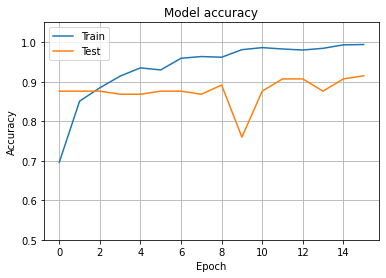

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

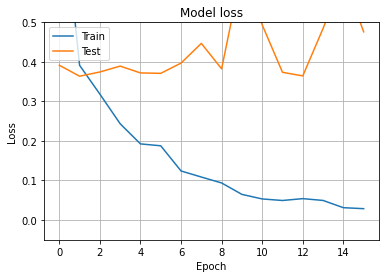

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("tanimura.h5")